# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

In [191]:
import re
import os
import shutil
import pandas as pd
import numpy as np
import scipy as sp
import folium
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()
from pyspark.sql.types import DoubleType

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import unix_timestamp, udf, to_date, to_timestamp
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
from datetime import datetime

from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

from pyspark.sql.types import *

from pyspark.sql.types import StructType, StructField, IntegerType

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from ada_const import *
from ada_context import *
from ada_imports import *
from ada_dataIO import *
from ada_dataCleaner import *

import country_converter as coco
cc = coco.CountryConverter()
from branca.colormap import linear
import seaborn as sns

import json
import folium
from folium.plugins import HeatMap, HeatMapWithTime, TimeSliderChoropleth


import plotly.plotly as py
import plotly
import plotly.graph_objs as go
#plotly.tools.set_credentials_file(username='ADAforever1', api_key='TTknVnm05Dc3wX5nddyo')
#plotly.tools.set_credentials_file(username='bizeul', api_key='jSU2N3rJ4ayKdWPPRhIP')
#plotly.tools.set_credentials_file(username='ADAforever3', api_key='0xBFonoWBSbUM0oEOD6w')
plotly.tools.set_credentials_file(username='bizeul1', api_key='VqW3YPsRnUTv6PQfbyyg')

In [2]:
OUT_DIR = 'output'
DATA_DIR = './data_sample'


def save(df):
    df.write.mode('overwrite').csv('df_save')


spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext

events = spark.read.csv(os.path.join(DATA_DIR, "*.export.CSV"), sep="\t", schema=EVENTS_SCHEMA)
mentions = spark.read.csv(os.path.join(DATA_DIR, "*.mentions.CSV"), sep="\t", schema=MENTIONS_SCHEMA)

In [3]:
events = cleanEvents(events)
mentions = cleanMentions(mentions)

events.registerTempTable('events')
mentions.registerTempTable('mentions')

In [4]:
mentions.printSchema()

root
 |-- GLOBALEVENTID: long (nullable = true)
 |-- EventTimeDate: timestamp (nullable = true)
 |-- MentionTimeDate: timestamp (nullable = true)
 |-- MentionType: long (nullable = true)
 |-- Confidence: long (nullable = true)
 |-- MentionSourceName: string (nullable = true)



In [5]:
events.printSchema()

root
 |-- GLOBALEVENTID: long (nullable = true)
 |-- date: date (nullable = true)
 |-- Day_Date: integer (nullable = true)
 |-- Month_Date: integer (nullable = true)
 |-- Year_Date: string (nullable = true)
 |-- MonthYear_Date: string (nullable = true)
 |-- FractionDate: float (nullable = true)
 |-- EventCode: string (nullable = true)
 |-- EventRootCode: string (nullable = true)
 |-- QuadClass: long (nullable = true)
 |-- GoldsteinScale: float (nullable = true)
 |-- AvgTone: float (nullable = true)
 |-- ActionGeo_CountryCode: string (nullable = true)



In [6]:
events.toPandas().head()

,GLOBALEVENTID,date,Day_Date,Month_Date,Year_Date,MonthYear_Date,FractionDate,EventCode,EventRootCode,QuadClass,GoldsteinScale,AvgTone,ActionGeo_CountryCode
0,513222668,2015-02-18,18,2,2015,201502,2015.13147,173,17,4,-5.0,-8.724833,US
1,513222669,2015-02-18,18,2,2015,201502,2015.13147,192,19,4,-9.5,-0.093023,UK
2,513222670,2015-02-18,18,2,2015,201502,2015.13147,192,19,4,-9.5,-0.093023,HK
3,513222671,2015-02-18,18,2,2015,201502,2015.13147,172,17,4,-5.0,-3.216374,WS
4,513222672,2015-02-18,18,2,2015,201502,2015.13147,173,17,4,-5.0,-8.724833,US


In [7]:
mentions.toPandas().head()

,GLOBALEVENTID,EventTimeDate,MentionTimeDate,MentionType,Confidence,MentionSourceName
0,561424024,2016-07-19 15:30:00,2017-07-19 23:00:00,1,30,mycentraljersey.com
1,561311330,2016-07-19 08:30:00,2017-07-19 23:00:00,1,70,997wtn.com
2,674391787,2017-07-19 20:30:00,2017-07-19 23:00:00,1,10,997wtn.com
3,674399315,2017-07-19 21:30:00,2017-07-19 23:00:00,1,100,seattlepi.com
4,674415400,2017-07-19 23:00:00,2017-07-19 23:00:00,1,40,whitehouse.gov


# Data Exploration

For the exploration of the database, we will be using a sample of the data (mentions and events) provided on the cluster. The chosen samples were spread over time in order to have a more reliable estimation of the distribution of the data across time. Indeed, we took a file of mentions and events for each month from the beginning to the end of the recording of mentions.

In [8]:
print('{} events are reported in our events sample dataset'.format(events.count()))
print('{} mentions are reported in our mentions sample dataset'.format(mentions.count()))

52834 events are reported in our events sample dataset
255361 mentions are reported in our mentions sample dataset


We see here that we have more mentions than we have events. This is consistent with the nature of the 2 databases. Indeed, the mentions database records for each event all the news sources in which the events were mentioned. Thus, an event is represented by as many mentions as there are news sources which mentioned it. 

In [9]:
# When were the mentions collected ? 
def get_period_mentions(df_mentions):
    
    start = df_mentions.select('MentionTimeDate').orderBy('MentionTimeDate').head()
    stop = df_mentions.select('MentionTimeDate').orderBy(desc('MentionTimeDate')).head()
    
    return start[0], stop[0]

In [10]:
start,stop = get_period_mentions(mentions)
print('Mentions collection started on {} and stoped on {}'.format(start,stop))

Mentions collection started on 2015-03-19 00:00:00 and stoped on 2017-11-20 00:00:00


In [11]:
# When did the events recorded in the sample of mentions take place? 
def get_period_events_mentions(df_mentions):
    
    start = df_mentions.select('EventTimeDate').orderBy('EventTimeDate').head()
    stop = df_mentions.select('EventTimeDate').orderBy(desc('EventTimeDate')).head()
    
    return start[0], stop[0]

In [12]:
start,stop = get_period_events_mentions(mentions)
print('Events mentioned in the sample of mentions took place from {} to {}'.format(start,stop))

Events mentioned in the sample of mentions took place from 2015-01-18 01:15:00 to 2017-11-20 00:00:00


In [13]:
# When did the recorded events take place?
def get_period_events(df_events):
    
    start = df_events.select('date').orderBy('date').head()
    stop = df_events.select('date').orderBy(desc('date')).head()
    
    return start[0], stop[0]

In [14]:
start,stop = get_period_events(events)
print('Events recorded in the sample of events started on {} and stoped on {}'.format(start,stop))

Events recorded in the sample of events started on 2015-02-18 and stoped on 2017-09-19


We see that the first recorded events took place before the collection of mentions started. Indeed, mentions refering to events which happened in the past will lead to the recording of these events in the database. 

# Origin of our data

The news reports we will be using accross this project are gathered from different types of news source : 

- Web sources (1)
- Broadcasts, prints, other offline sources (2)
- CORE archives (3)
- DTIC archives (4)
- JSTOR archives (5)
- NonTextual sources (6)

Let's explore the origin of the news reports we will be analysing :


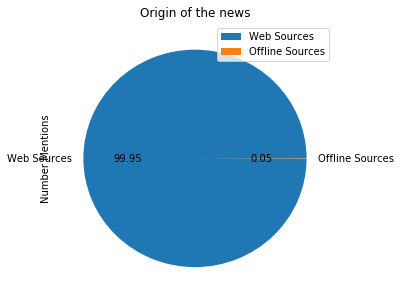

In [15]:
labels_val = ['Web Sources','Offline Sources','CORE Archives','DTIC Archives','JSTOR Archives','Non Textual Sources']

def get_labels(labels):   
    return [x for i,x in enumerate(labels_val) if (i+1) in labels]
    
def get_sources(df_mentions):
    
    sources = df_mentions.groupby('MentionType').agg(count('GLOBALEVENTID').alias('Number Mentions')).orderBy('MentionType')
    
    mentions_list = list(sources.select('Number Mentions').toPandas()['Number Mentions'])
    source_list = list(sources.select('MentionType').toPandas()['MentionType'])

    return pd.DataFrame({'Number Mentions': mentions_list},index= source_list)

sources = get_sources(mentions)
sources.plot.pie(y='Number Mentions', autopct='%.2f',figsize=(5, 5),labels=get_labels(list(sources.index)), title ='Origin of the news')


As seen above, almost all sources are websources. This is consistent with the habits of people today, who will tend to look at the news on their computer or on their phone while they are on their way. This lead to the developement of more websources to satisfy the readers. Not so many people are reading newspapers anymore. 

Now we would like to have a more specific overview of the different medias which report the news. We thus look at the medias which mentioned the most events over the 2 years. 

In [16]:
mentions.select('MentionSourceName').show()

+-------------------+
|  MentionSourceName|
+-------------------+
|mycentraljersey.com|
|         997wtn.com|
|         997wtn.com|
|      seattlepi.com|
|     whitehouse.gov|
|     whitehouse.gov|
|channelnewsasia.com|
|         nasdaq.com|
|             al.com|
|heraldmailmedia.com|
|mycentraljersey.com|
|heraldmailmedia.com|
|heraldmailmedia.com|
|mycentraljersey.com|
|heraldmailmedia.com|
|heraldmailmedia.com|
|      seattlepi.com|
|        fortune.com|
|        fortune.com|
|      inquisitr.com|
+-------------------+
only showing top 20 rows



In [17]:
def get_sources_names(df_mentions) :
    return df_mentions.groupBy('MentionSourceName').count().orderBy(desc('count')).limit(80)

In [18]:
sources = get_sources_names(mentions.select('MentionSourceName'))
sources.show()

+-------------------+-----+
|  MentionSourceName|count|
+-------------------+-----+
|         iheart.com| 4230|
|          yahoo.com| 2623|
|             ap.org| 2052|
|    english.wafa.ps| 1409|
|        reuters.com| 1347|
|    dailymail.co.uk| 1299|
|          abc-7.com|  954|
|  news-sentinel.com|  878|
|     indiatimes.com|  878|
|         news12.com|  815|
|         sfgate.com|  785|
|    miamiherald.com|  780|
|         tucson.com|  775|
| washingtonpost.com|  743|
|            wnd.com|  743|
|billingsgazette.com|  737|
|      xinhuanet.com|  736|
|     missoulian.com|  733|
| couriermail.com.au|  733|
|       stltoday.com|  726|
+-------------------+-----+
only showing top 20 rows



We see that among the most prevalent medias are many american news sources like the broadcast and internet radio iheart.com (USA, Canada, New Zealand, Australia), the search engine yahoo.com, the newspaper/radio/television news agency ap.org, the american broadcasting company abc7 and other american news relating medias (news-sentinel, wnd, news12, tucson, miamiherald, sfgate, missoulian, washingtonpost, huffingtonpost...).

The most prevalent medias also count the british international news agency reuters.com and newspaper DailyMail.co.uk, the Palestine news agency Wafa, the australian Courier Mail, the indian indiatimes and the chinese news agency xinhuanet.

# Confidence in our data

After seeing the sources of the mentions, we want to have an overview of the mentions themselfes. The mentions dataframe provides an estimation of the confidence at which an event was extracted from a news report. If a news report is focuses on an event, the confidence ratio at which this event is detected is higher than in news report where the event is only briefly mentionned.

As a first insight in our data, let's see the distribution of this ratio accross our mention dataframe :

In [19]:
# Getting the percentage of mentions for each confidence value
def get_confidence(df_mentions):
    
    total_mentions = df_mentions.count()
    udf = UserDefinedFunction(lambda x: x/total_mentions, DoubleType())
    
    confidence = df_mentions.groupby('Confidence').agg(count('GLOBALEVENTID').alias('Number Mentions')).orderBy('Confidence')
    confidence = confidence.select([udf(column).alias('Percentage of Mentions') 
                                    if column == 'Number Mentions' else column for column in confidence.columns])
    
    return confidence

In [20]:
confidence = get_confidence(mentions).toPandas()

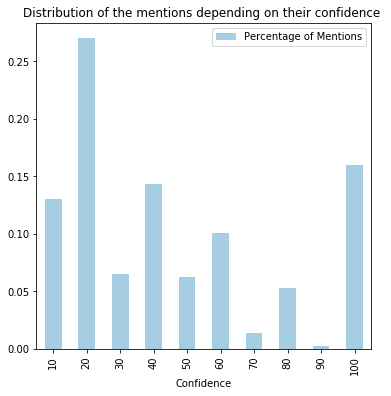

In [21]:
confidence.plot.bar(x='Confidence', y='Percentage of Mentions', figsize=(6, 6), colormap='Paired',
                    title = 'Distribution of the mentions depending on their confidence ')

As seen above, a consequent part of the reported mentions have a low confidence ratio. Indeed, more than 50% of the mentions have less than 50% confidence. This means that most of the recorded events are mentioned briefly in the news and have not entire news reports dedicated to them. 

We decided to investigate whether this repartition was different depending on the mention source type.

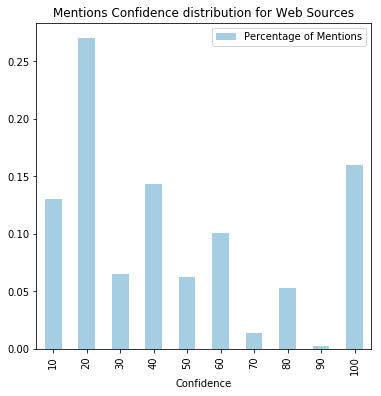

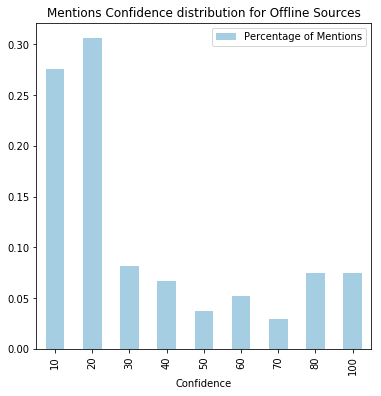

In [22]:
for index,label in enumerate(labels_val):

    sources_index = mentions['MentionType'] == str(index+1)
    sources = mentions[['GLOBALEVENTID','MentionType', 'Confidence']][sources_index]
    
    if not sources.toPandas().empty :
        confidence = get_confidence(sources).toPandas()
        confidence.plot.bar(x='Confidence', y='Percentage of Mentions', figsize=(6, 6), 
                            colormap='Paired',title = 'Mentions Confidence distribution for '+label)

The previous plots show that roughly 35 % of mentions in web sources have a confidence level of 20% or less. This lack of confidence is slightly stronger for the offline sources, which represent less than 1% of mentions sources. 
To get more reliable results through out our projets, the decision was made to consider only news mentions with a confidence level of at least 20%. Indeed, we want to study events which were seriously reported by the news and not briefly written down. We thus removed the mentions with a confidence inferior to 20% :

In [23]:
def get_goodConfidence(df_mentions):
   
    index = df_mentions['Confidence'] > 20

    return df_mentions[df_mentions.schema.names][index]

mentions = get_goodConfidence(mentions)
mentions.show(5)

+-------------+-------------------+-------------------+-----------+----------+-------------------+
|GLOBALEVENTID|      EventTimeDate|    MentionTimeDate|MentionType|Confidence|  MentionSourceName|
+-------------+-------------------+-------------------+-----------+----------+-------------------+
|    561424024|2016-07-19 15:30:00|2017-07-19 23:00:00|          1|        30|mycentraljersey.com|
|    561311330|2016-07-19 08:30:00|2017-07-19 23:00:00|          1|        70|         997wtn.com|
|    674399315|2017-07-19 21:30:00|2017-07-19 23:00:00|          1|       100|      seattlepi.com|
|    674415400|2017-07-19 23:00:00|2017-07-19 23:00:00|          1|        40|     whitehouse.gov|
|    561192359|2016-07-19 00:15:00|2017-07-19 23:00:00|          1|        80|         nasdaq.com|
+-------------+-------------------+-------------------+-----------+----------+-------------------+
only showing top 5 rows



In [24]:
print('After removal of the mentions with less than 20% of condidence, {} mentions were left in our mentions sample dataset'.format(mentions.count()))


After removal of the mentions with less than 20% of condidence, 153172 mentions were left in our mentions sample dataset


# Mentions , Mediatic Coverge and Mediatic Attention

Our project will be centered around the evaluation of the bias of medias towards specific locations and event types worldwide. 
To achieve this, an indicator of media coverage and media attention should be defined. This will be achieved by using the mentions database, which reports every 15 minutes all news reports of events in the news. Each row in this database records a acticle/news report which mentioned at least once a specific event. 

#### Media Coverage :
Media coverage will be defined as the number of mentions in news report that an event will receive within 120 days (4 months) posterior to its occurence. This time period was set to avoid the bias of the date of occurence of the event. Indeed, our database records mentions from February 2015 to November 2017. Each event should be considered on an equivalent period of time to have equal chance of being mentioned. Otherwise, events recorded at the beginning of the database will have more chance to be mentioned than events happening at the end of the recording.  
As explicited above, another restriction will be applied to our mentions database : only mentions with a confidence ratio above 20% will be considered.

#### Mediatic Attention:
In order to grasp the level of attention perceived by an event on the mediactic scene, we should compute the mediatic attention index.  This index will be considered as the ratio between media coverage and the total amount of mentions reported in the database during the equivalent period of time. This normalisation procedure allows to avoid a biased perception and compare the level of atention perceived by events. 

Let's first observe the distribution of mediatic coverage by event within our database, after restricting the mentions to the ones recorded 4 months after the first recording of an event : 

In [25]:
def get_delay(df_mentions):
    # Get delay between event time and mention time
    
    timeFmt = "yyyy-MM-dd'T'HH:mm:ss.SSS"
    timeDiff = (unix_timestamp('MentionTimeDate', format=timeFmt) - unix_timestamp('EventTimeDate', format=timeFmt))
    
    return df_mentions.withColumn("Mention delay", timeDiff)

def restric_cov(df_mentions, days_threshold):
    # Narrow down mentions to 2 month posterior to event mentions
    
    restric_index = df_mentions['Mention Delay'] <= days_threshold*24*3600
    
    return df_mentions[df_mentions.schema.names][restric_index].sort('GLOBALEVENTID')

mentions = restric_cov(get_delay(mentions),120)
mentions.count()

152892

In [26]:
def get_media_cov(df_mentions):
    # Computing the mediatic coverage of each event in the mentions database
    
    return df_mentions.groupby('GLOBALEVENTID').agg(count('GLOBALEVENTID').alias('Number Mentions'))

med_cov = get_media_cov(mentions.select('GLOBALEVENTID'))
med_cov.select('Number Mentions').describe().show()

+-------+------------------+
|summary|   Number Mentions|
+-------+------------------+
|  count|             93866|
|   mean|1.6288325911405621|
| stddev| 2.300172946502235|
|    min|                 1|
|    max|                94|
+-------+------------------+



Text(0.5,1,'Distribution of mediatic coverage per event')

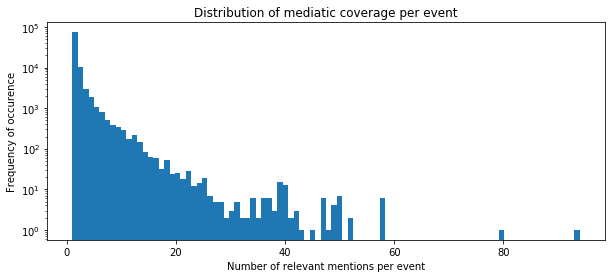

In [27]:
#Showing the distribution of mediatic coverage in database
med_cov = med_cov.toPandas()
fig = plt.subplots(figsize=(10,4))
plt.hist(med_cov['Number Mentions'],bins = med_cov['Number Mentions'].max())
plt.yscale('log')
plt.xlabel('Number of relevant mentions per event')
plt.ylabel('Frequency of occurence')
plt.title('Distribution of mediatic coverage per event')

As we have seen above, each row in the mentions database represents a mention of an event in a specific news report. Here we observe that the most frequent number of mentions is one, leading to the conclusion that a large amount of events receive very low mediatic coverage. However, we shall not forget that we are doing our analysis on a small subset of data and that we are missing out a certain amounts of mentions. There are however a few events which were mentioned quite a lot. Since we have data for the recording of mentions for 15 minutes each month, we can assume that the few events which lead to more mentions were widely reported right after they happened. They must be important events as they significantly raised the interest of the medias right after they happened. 

# Time
After looking at the distributions of the mentions in the different sources, we would like to display the distribution of the mentions througout the months, to evaluate the media coverage. We would also like to display the distribution of the events reported in the medias througout the months, to evaluate the human activity. This will allow us to see how the data is distributed and to visualize any particular behavior with respect to time.

### Human activity worldwide throughout the months
We represent the distribution of human activity wordlwide throughout the months, that is the number of events taking place each month, according to the medias.

In [28]:
# WORLDWIDE
def get_events_worldwide(events_df):
    
    udf = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m').strftime('%m-%Y'))
    
    events_worldwide =  events_df.groupBy('MonthYear_Date').count().orderBy('MonthYear_Date')
    return events_worldwide.select([udf(column).alias('Month_Year') if column == 'MonthYear_Date' else column for column in events_worldwide.columns])
   

In [29]:
events_worldwide_time = get_events_worldwide(events)

Text(0.5,1,'Number of events worldwide during 2 years')

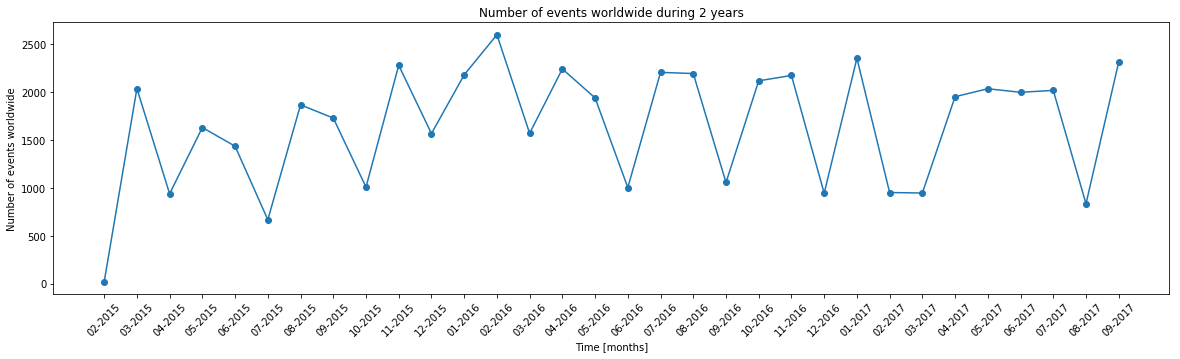

In [30]:
events_worldwide_time = events_worldwide_time.toPandas()
fig = plt.subplots(figsize=(20,5))
plt.plot(events_worldwide_time['Month_Year'], events_worldwide_time['count'],marker='o')
plt.xlabel('Time [months]')
plt.ylabel('Number of events worldwide')
plt.xticks(rotation=45)
plt.title('Number of events worldwide during 2 years')

The database contains events which are located prior in time to the beginning of the recording of mentions in the database, in February 2015. This in fact is due to the fact that mentions reference to events which just happened but also to events which happened in the past, and which will thus be registered in the database. However, since most of the events are referenced in the news right after they happened, these events will have less mentions than the ones which happened after the beginning of the recording. We thus choose to remove the events which happened prior to the beginning of the recording, in order to have an accurate idea of the total number of mentions per event.

The last events recorded are in november 2017, which is consistent with the end time of the database we have access to. 

We now create a function which is going to remove the events which took place before the first mentions.

In [31]:
def clean_events (events_df) :

    # first mention recording
    first_record = datetime.strptime('20150218', '%Y%m%d').strftime('%Y-%m-%d')
    # last event considered to have 2 months coverage for every event
    last_considered_events = datetime.strptime('20170921', '%Y%m%d').strftime('%Y-%m-%d')
    new_events = events_df.filter(events_df['date']>=first_record)
    clean_new_events = new_events.filter(new_events['date']<= last_considered_events)
    
    return clean_new_events

In [32]:
events = clean_events(events)
# check that the day of the first event is now the day of the first mention
start = events.select('date').orderBy('date').head()
end = events.select('date').orderBy(desc('date')).head()
print(start)
print(end)

Row(date=datetime.date(2015, 2, 18))
Row(date=datetime.date(2017, 9, 19))


Text(0.5,1,'Number of events worldwide during 2 years')

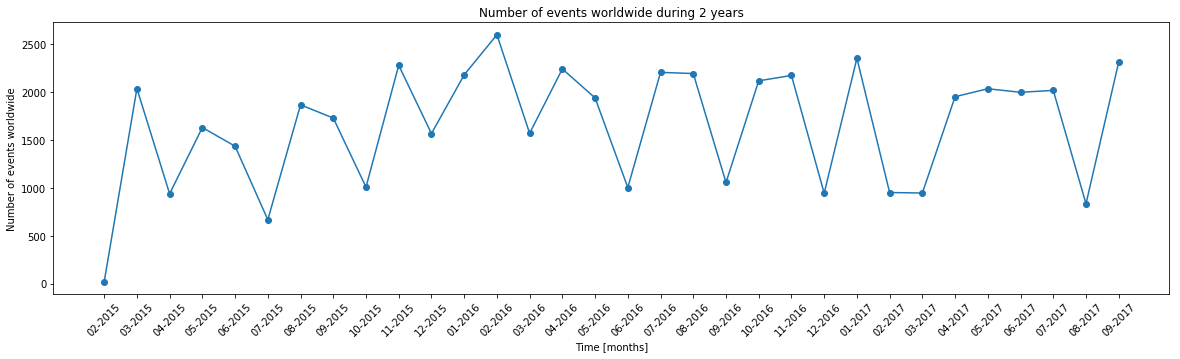

In [33]:
# new representation of the events, once the events taking place before the recording of the first mentions have been removed
events_worldwide_time = get_events_worldwide(events)
events_worldwide_time = events_worldwide_time.toPandas()
fig = plt.subplots(figsize=(20,5))
plt.plot(events_worldwide_time['Month_Year'], events_worldwide_time['count'],marker='o')
plt.xlabel('Time [months]')
plt.ylabel('Number of events worldwide')
plt.xticks(rotation=45)
plt.title('Number of events worldwide during 2 years')

### Number of mentions worldwide throughout the months
We represent the distribution of the worldwide media coverage throughout the months, that is the number of mentions per month.

In [34]:
# WORLDWIDE
udf_mention1 = UserDefinedFunction(lambda x: x.strftime('%Y%m'))
udf_mention2 = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

# returns the number of mentions for each month, regardless of the countries
def get_media_coverage_worldwide(mentions_df) :
    
    mentions_Year_Month = mentions_df.select([udf_mention1(column).alias('Year_Month_Mention') if column == 'MentionTimeDate' else column for column in mentions_df.columns])
    mentions_year_month = mentions_Year_Month.groupBy('Year_Month_Mention').count().orderBy('Year_Month_Mention') 
    mentions_month_year = mentions_year_month.select([udf_mention2(column).alias('Month_Year_Mention') if column == 'Year_Month_Mention' else column for column in mentions_year_month.columns])
    
    return mentions_month_year

In [35]:
mentions_worldwide_time = get_media_coverage_worldwide(mentions.select('MentionTimeDate'))

In [36]:
mentions_worldwide_time.show()

+------------------+-----+
|Month_Year_Mention|count|
+------------------+-----+
|           03-2015| 5652|
|           04-2015| 2312|
|           05-2015| 4268|
|           06-2015| 4330|
|           07-2015| 2587|
|           08-2015| 4970|
|           09-2015| 4660|
|           10-2015| 3435|
|           11-2015| 5629|
|           12-2015| 4151|
|           01-2016| 5395|
|           02-2016| 6258|
|           03-2016| 4912|
|           04-2016| 5489|
|           05-2016| 5320|
|           06-2016| 2666|
|           07-2016| 6074|
|           08-2016| 5099|
|           09-2016| 2758|
|           10-2016| 4985|
+------------------+-----+
only showing top 20 rows



Text(0.5,1,'Number of mentions worldwide during 2 years')

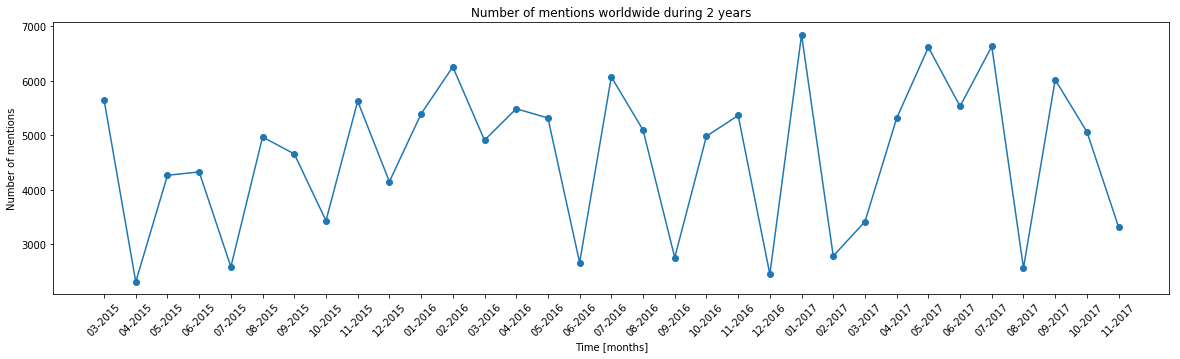

In [37]:
mentions_worldwide_time = mentions_worldwide_time.toPandas()
fig = plt.subplots(figsize=(20,5))
plt.plot(mentions_worldwide_time['Month_Year_Mention'], mentions_worldwide_time['count'],marker='o')
plt.xlabel('Time [months]')
plt.ylabel('Number of mentions')
plt.xticks(rotation=45)
plt.title('Number of mentions worldwide during 2 years')


The first mentions were in February 2015 and the last mentions were in November 2017, which is consistent with the time range of recording that we have access to, from February 18th 2015 at 11pm to November 23th 2017 at 8am. 

### Evolution of mentions for an event througout the months
Now that we have had a rough overview of how events and mentions are distributed througout time, we would like to see how the mentions for a specific event are distributed througout time. We choose to select events which are mentioned a lot and which can give an actual idea of what happens across time, unlike small events which are only mentioned a few times.

In [38]:
# get the 50 events which are the most mentioned during the 2 years
largest_events = mentions.groupBy('GLOBALEVENTID').count().orderBy(desc('count')).limit(15)
largest_events.show()

+-------------+-----+
|GLOBALEVENTID|count|
+-------------+-----+
|    450310742|   94|
|    674257761|   80|
|    503390947|   58|
|    503428919|   58|
|    503428907|   58|
|    503428909|   58|
|    503429589|   58|
|    503429920|   58|
|    503145802|   52|
|    551686824|   52|
|    434214317|   50|
|    434214228|   50|
|    434214325|   50|
|    434241712|   50|
|    589971588|   50|
+-------------+-----+



In [39]:
ids_list = largest_events.select('GLOBALEVENTID').collect()


In [40]:
ids_array = [int(i.GLOBALEVENTID) for i in ids_list]

In [41]:
mentions_filtered = mentions.filter(col('GLOBALEVENTID').isin(ids_array))

In [42]:
mentions_filtered.select('GLOBALEVENTID').distinct().show()

+-------------+
|GLOBALEVENTID|
+-------------+
|    434214228|
|    434214325|
|    434241712|
|    450310742|
|    503145802|
|    503390947|
|    503428907|
|    503428909|
|    503428919|
|    503429589|
|    503429920|
|    551686824|
|    589971588|
|    590299180|
|    674257761|
+-------------+



In [43]:
udf_mention3 = UserDefinedFunction(lambda x: x.strftime('%Y%m%d'))
udf_mention4 = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m%d').strftime('%d-%m-%Y'))

# finds each mention of the most mentioned events
largest_events_time = largest_events.select('GLOBALEVENTID').join(mentions_filtered.select('GLOBALEVENTID','MentionTimeDate'), 'GLOBALEVENTID')
# finds the number of mentions per month for the most mentioned events (converts to a conveniable time format)
largest_events_Year_Month = largest_events_time.select([udf_mention3(column).alias('Year_Month_Mention') if column == 'MentionTimeDate' else column for column in largest_events_time.columns])
largest_events_year_month = largest_events_Year_Month.groupBy('Year_Month_Mention','GLOBALEVENTID').count().orderBy('Year_Month_Mention') 
largest_events_month_year = largest_events_year_month.select([udf_mention4(column).alias('Month_Year_Mention') if column == 'Year_Month_Mention' else column for column in largest_events_year_month.columns])
    
largest_events_month_year.show()

+------------------+-------------+-----+
|Month_Year_Mention|GLOBALEVENTID|count|
+------------------+-------------+-----+
|        19-05-2015|    434214228|   50|
|        19-05-2015|    434241712|   50|
|        19-05-2015|    434214325|   50|
|        19-07-2015|    450310742|   94|
|        19-01-2016|    503428909|   58|
|        19-01-2016|    503429589|   58|
|        19-01-2016|    503429920|   58|
|        19-01-2016|    503428919|   58|
|        19-01-2016|    503428907|   58|
|        19-01-2016|    503390947|   58|
|        19-01-2016|    503145802|   52|
|        19-06-2016|    551686824|   52|
|        19-10-2016|    589971588|   50|
|        20-07-2017|    674257761|   80|
+------------------+-------------+-----+



In [44]:
# for each event, looks whether its related mentions happened in the same month (not duplicated = FALSE) or in different month (duplicated = TRUE)
largest_events_month_year.toPandas().duplicated(subset='GLOBALEVENTID', keep='first').unique()


array([False])

We see here that the 50 events which are mentioned the most are mentioned only in the 15 minutes after which they were first mentioned. That is why their ID appear only one througout the largest_events_month_year dataframe, where the mentions for each events are stored during the months. However, for this descriptive analysis of the dataset, we are only considering 15 minutes of mentions per month. Thus, the most mentioned events probably have other mensions througout the year, but we are not aware of that because we only have a small subset of the data. To conclude, the results here are not significative. We would need data over a whole month to do a deeper analysis of the mentions of an event througout time. 

# Geography
Now that we have seen the distribution of the mentions across time, we would like to have an idea of their geographic distribution in the different countries. This will give us an idea of the medias in the different countries, as well as giving us an insight on a query we would like to achieve in further analysis, that is whether the media coverage is biased by the country in which the event takes place.

### Human activity per country (average over the 2 years)
We represented the distribution of events in the different countries over the 2 years, to see in which countries there seems to be more events taking place, according to the information related in the medias.

In [45]:
# number of events for each country
def get_events_country(df_events) :
    
    return df_events.groupBy('ActionGeo_CountryCode').agg(count('GLOBALEVENTID').alias('human_activity')).orderBy('human_activity') 


In [46]:
events_country = get_events_country(events)

In [47]:
events_country = events_country.toPandas()
events_country.tail()

,ActionGeo_CountryCode,human_activity
214,AS,1627
215,IN,1660
216,CA,1753
217,UK,1787
218,US,22332


Text(0.5,1,'Human activities related through the medias across countries')

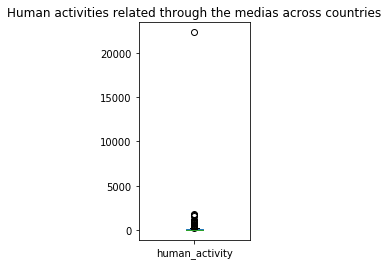

In [48]:
# boxplot of the number of events of each country
fig = plt.subplots(figsize=(2,4))
events_country.boxplot(column='human_activity', grid=False)
plt.title('Human activities related through the medias across countries')

In [49]:
events_country.describe()

,human_activity
count,219.000000
mean,241.251142
std,1528.675578
min,1.000000
25%,10.000000
50%,31.000000
75%,115.000000
max,22332.000000


In [50]:
# outlier countries in terms of human activity in the countries over the 2 years
outliers = events_country[(np.abs(events_country.human_activity-events_country.human_activity.mean()) > (3*events_country.human_activity.std()))]
outliers.head()

,ActionGeo_CountryCode,human_activity
218,US,22332


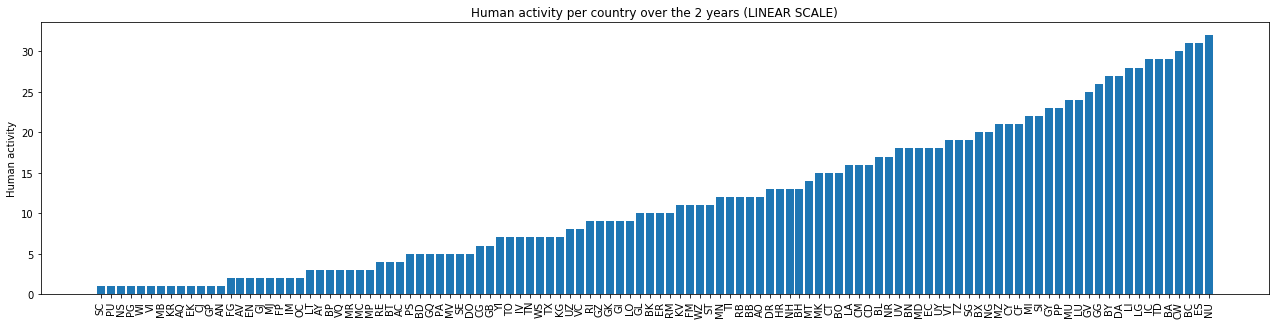

In [51]:
# represents the human activity over the 2 years for the countries in which less events took place (LINEAR SCALE)
events_country_less = events_country[events_country['human_activity']<33]
x_pos = np.arange(len(events_country_less['human_activity']))
fig, ax = plt.subplots(figsize=(22,5))
ax.bar(x_pos, events_country_less['human_activity'])
ax.set_xticks(x_pos)
ax.set_xticklabels(events_country_less['ActionGeo_CountryCode'])
ax.set_ylabel('Human activity')
ax.set_title("Human activity per country over the 2 years (LINEAR SCALE)")
plt.xticks(x_pos, events_country_less['ActionGeo_CountryCode'], rotation='vertical')
plt.show()

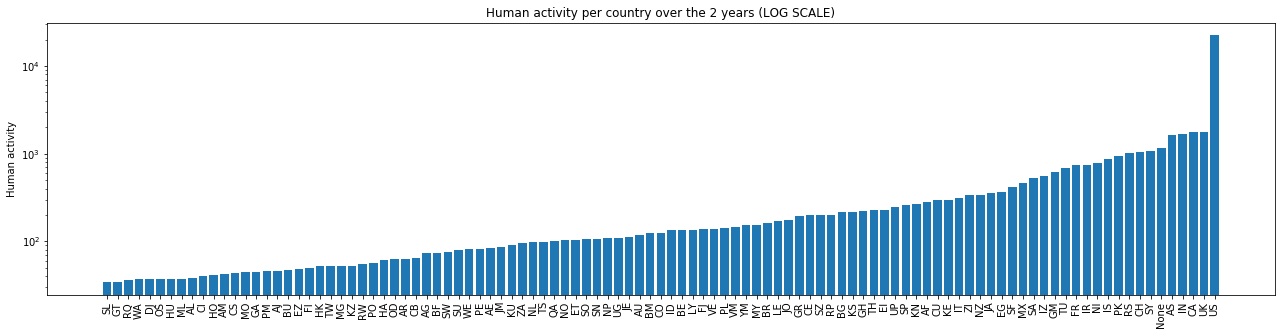

In [52]:
# represents the human activity over the 2 years for the countries in which more events took place 
# LOG SCALE because the US are a major outlier and prevent from seeing the other countries on a linear scale
events_country_more = events_country[events_country['human_activity']>33]
x_pos = np.arange(len(events_country_more['human_activity']))
fig, ax = plt.subplots(figsize=(22,5))
ax.bar(x_pos, events_country_more['human_activity'])
ax.set_yscale('log')
ax.set_xticks(x_pos)
ax.set_xticklabels(events_country_more['ActionGeo_CountryCode'])
ax.set_ylabel('Human activity')
ax.set_title("Human activity per country over the 2 years (LOG SCALE)")
plt.xticks(x_pos, events_country_more['ActionGeo_CountryCode'], rotation='vertical')
plt.show()

According to the informations related through the medias, the United States (US) seem to be the country where most of the human activity is taking place. Indeed, they are a clear outlier in the distribution of human activity, because their number of events is way above the median. Canada (CA) is also highly represented in terms of human activity. This might be because most of the news sources considered by the database come from the USA and will thus tend to display the events taking place in the country itself and in the bordering countries. 

What we also observe is that many events are associated with no country (None), which means that an important amount of events from the database are misclassified in terms of geographical location. However, since we have a huge amount of data, we chose to remove these events in the future, when we will represent features per country.

We observe that according to the news, the countries which have less events taking place are countries from South America, Africa and East Europe (Roumania, Guatemala, Namibie, Djibouti, Mali, Honduras...). This might be because less medias report events from these countries or because the database doesn't have access to their medias. This might also just be because there are less events at the samples of time during which the recording were considered.

### Media coverage and mediatic attention per country (average over the 2 years)
We looked at the distribution of media coverage and mediatic attention in the countries, to have an idea of the countries which are more present in the news. As a reminder, we consider the media coverage as the amount of mentions an event will receive in the 4 months following its recording. Here we look at the media coverage of all the events related to a country during the 2 years of recording. 
On the other hand, the mediatic attention (in percentage %) represents the attention an event receives in the medias on the wider scene. Here we look at the mediatic attention that the events of a country receive on the international scene, that is how much attention a country receives in the news, compared to another.  

In [53]:
# returns the media coverage for each country over the 2 years
def get_media_coverage_country(events_df,mentions_df) :
    
    # mentions per event
    mentions_count = mentions_df.groupBy('GLOBALEVENTID').count()
    mentions_count1 = mentions_count.join(events_df, 'GLOBALEVENTID')
    # mentions per country over the 2 years (= media coverage)
    country_count = mentions_count1.groupBy('ActionGeo_CountryCode').agg(sum('count').alias('media_coverage')).orderBy(desc('media_coverage'))
    # total number of mentions for all the events of the dataset which were recorded in the mentions dataset
    total = mentions_df.join(events, 'GLOBALEVENTID').count()
    # percentage of mentions per country over worldwide mentions over the 2 years (= mediatic attention)
    country_count = country_count.withColumn('media_attention', col('media_coverage')/total)
    country_count = country_count.withColumn('media_attention', col('media_attention')*100)
    return country_count


In [54]:
media_countries = get_media_coverage_country(events, mentions)

In [55]:
media_countries = media_countries.toPandas()
media_countries.head(20)

,ActionGeo_CountryCode,media_coverage,media_attention
0,US,13468,40.949862
1,AS,1289,3.919244
2,CA,1265,3.846271
3,None,1203,3.657758
4,UK,1117,3.396272
5,IN,1080,3.283773
6,CH,654,1.988507
7,SY,570,1.733102
8,PK,553,1.681413
9,RS,513,1.559792


Text(0.5,1,'Media attention across countries')

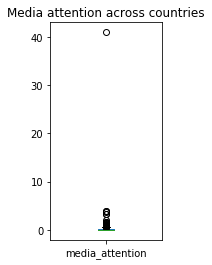

In [56]:
# boxplot of the media attention of each country
fig = plt.subplots(figsize=(2,4))
media_countries.boxplot(column='media_attention', grid=False)
plt.title('Media attention across countries')

In [57]:
media_countries.describe()

,media_coverage,media_attention
count,213.000000,213.000000
mean,154.408451,0.469484
std,939.184641,2.855619
min,1.000000,0.003041
25%,8.000000,0.024324
50%,19.000000,0.057770
75%,77.000000,0.234121
max,13468.000000,40.949862


In [58]:
# outlier countries in terms of media coverage over the 2 years
outliers = media_countries[(np.abs(media_countries.media_attention-media_countries.media_attention.mean()) > (3*media_countries.media_attention.std()))]
outliers.head()

,ActionGeo_CountryCode,media_coverage,media_attention
0,US,13468,40.949862


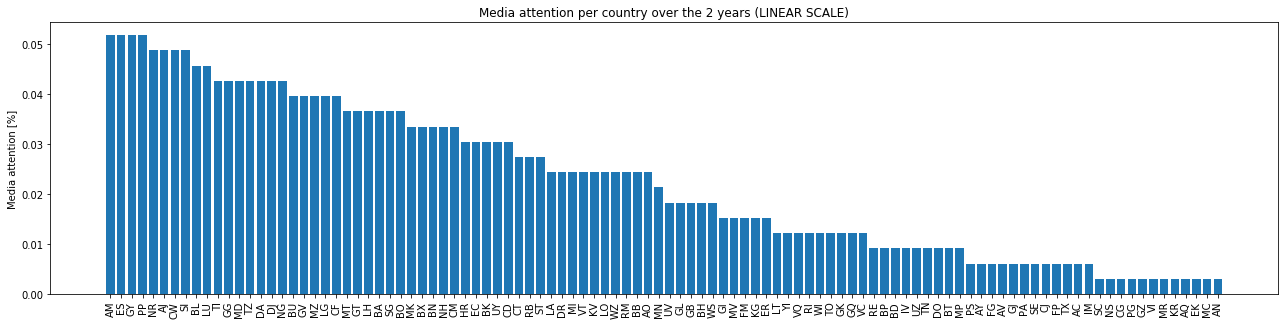

In [59]:
# represents the media attention over the 2 years for the countries which got less media attention (LINEAR SCALE)
media_country_less = media_countries[media_countries['media_attention']<0.054310]
x_pos = np.arange(len(media_country_less['media_attention']))
fig, ax = plt.subplots(figsize=(22,5))
ax.bar(x_pos, media_country_less['media_attention'])
ax.set_xticks(x_pos)
ax.set_xticklabels(media_country_less['ActionGeo_CountryCode'])
ax.set_ylabel('Media attention [%]')
ax.set_title("Media attention per country over the 2 years (LINEAR SCALE)")
plt.xticks(x_pos, media_country_less['ActionGeo_CountryCode'], rotation='vertical')
plt.show()

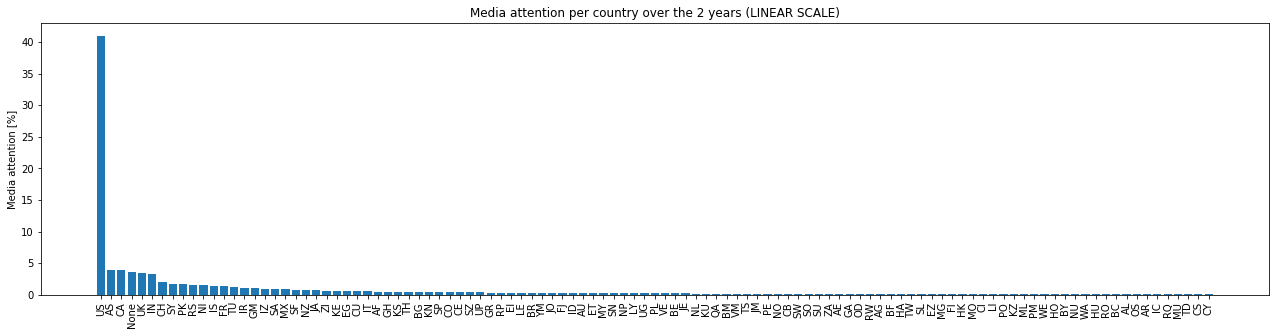

In [60]:
# represents the media attention over the 2 years for the countries which got more media attention (LINEAR SCALE)
media_country_more = media_countries[media_countries['media_attention']>0.054310]
x_pos = np.arange(len(media_country_more['media_attention']))
fig, ax = plt.subplots(figsize=(22,5))
ax.bar(x_pos, media_country_more['media_attention'])
ax.set_xticks(x_pos)
ax.set_xticklabels(media_country_more['ActionGeo_CountryCode'])
ax.set_ylabel('Media attention [%]')
ax.set_title("Media attention per country over the 2 years (LINEAR SCALE)")
plt.xticks(x_pos, media_country_more['ActionGeo_CountryCode'], rotation='vertical')
plt.show()

We see that the median and the 3rd quartile for the distribution of the media coverage and attention are extremely low, but the means are higher. This shows that there are some countries which are highly represented in the news and which pull the mean to higher value. We see that a clear outlier in the data is the US. This might be because, as we wrote earlier, most of the news sources are american and will thus get an easier access to the news in the US and in the bordering countries than to the news in more distant countries. On top of having a high media coverage, the USA have a high mediatic attention, meaning that they have a high weigh on the international mediatic stage.

We see that the countries which, according to the news, have the most events happening, are also the countries which get the most mediatic coverage and mediatic attention. For example United Kingdom (UK), Canada (CA), Australia (AU), China (CH), Pakistan (PK), Syria (SY) and Russsia (RS) are highly present in the medias, even though they are way behind the US. This is also consistent with the origins of the most prevalent media sources which are the UK, India, China and Australia. Indeed, these countries would naturally be more mentioned in the news if they have prominent news sources.

# Type of Event Bias

### Goldstein Ratio

One of the goal of our project is to assess the bias of mediatic attention towards the type of an event: Is there a direct correlation between the type of event and the mediatic attention is receives?
A way to perform this is to use the Goldstein ratio, which is a discrete numerical indicator between 10 and -10 that is directly linked to the event type. The Goldstein ratio assigned to each event type is directly linked to potential impact of this event on the country's stability : the larger the index, the more the event will lead to the strenghting of the country. The lower the index, the higher the chance that this event will weaken the country's stability.

Before performing statistical correlation between the Goldstein ratio and the mediatic attention, let's explore the distribution of the Goldstein Ratio accross events reported by news during the 2 years. 

Documentation on goldstein ratio and cameo event types : 
- https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt
- https://www.gdeltproject.org/data/lookups/CAMEO.goldsteinscale.txt

In [61]:
#What is the distribution of the Goldstein Ratio accross events
events.select('GoldsteinScale').describe().show()

+-------+------------------+
|summary|    GoldsteinScale|
+-------+------------------+
|  count|             52834|
|   mean|0.5023602247678137|
| stddev| 4.698186807352067|
|    min|             -10.0|
|    max|              10.0|
+-------+------------------+



In [62]:
# Get the number of events reported for each Goldstein ratio value
def get_activity_byGoldsetin(df_events):
    
    total_event = df_events.count()
    udf = UserDefinedFunction(lambda x: x/total_event, DoubleType())
    
    goldstein = df_events.groupby('GoldsteinScale').agg(count('GLOBALEVENTID').alias('Number Events')).orderBy('GoldsteinScale')
    goldstein = goldstein.select([udf(column).alias('Fraction of Events') if column == 'Number Events' else column for column in goldstein.columns])
    
    return goldstein

goldstein = get_activity_byGoldsetin(events).toPandas()


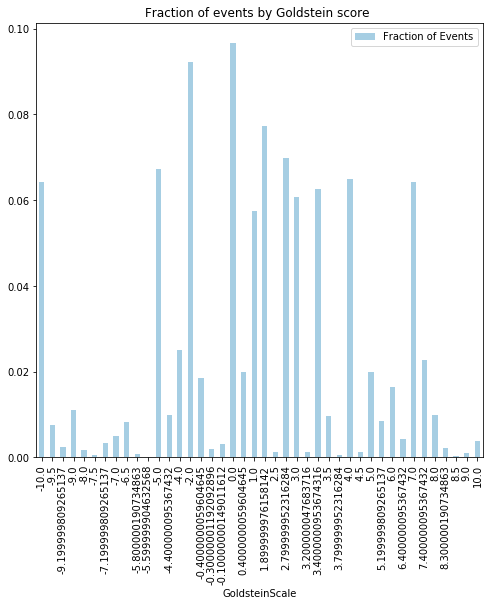

In [63]:
goldstein.plot.bar(x='GoldsteinScale', y='Fraction of Events', figsize=(8, 8), \
                   colormap='Paired',title = 'Fraction of events by Goldstein score ')

As seen above, the events displayed in the news are spread around a medium value on the Goldenstein scale, that is a value around 0. This means that these events should theoretically have no impact on a country's stability. What's more, most of the events have a score above zero. This leads us to believe that most of the human activity is leading toward the strengthening of the countries. However, eventhough few events are located between -10 and -5 on the scale, many reported events have a low Goldstein score of -10. Thus, there are more than 6% of the reported events which are destructive towards a country stability. We would like to investigate in our later analysis, whether this high percentage is accurately representative of an important amounts of negative events, or if it is just because these events are more related in the news.
​
Let's know get insight on the distribution of the mediatic coverage during the 2 years, regarding the Goldstein scale and therefore the event type :

In [64]:
# Get the media coverage for each goldstein score
def get_cov_index(df_events,df_mentions,index):
    
    # get_media_cov returns the number of mentions per event
    df_mentions = get_media_cov(df_mentions).alias('mentions')
    df_events = df_events.select(['GLOBALEVENTID',index]).alias('events')
    cov_index = df_events.join(df_mentions, df_events['GLOBALEVENTID'] == df_mentions['GLOBALEVENTID'],how = 'left').select(['events.'+index,'mentions.*'])
    cov_index = cov_index.where(cov_index[('GLOBALEVENTID')].isNotNull())
    cov_index = cov_index.groupBy('GoldsteinScale').agg(sum('Number Mentions').alias('Number Mentions')).sort('GoldsteinScale')
    
    return cov_index

goldstein2 = get_cov_index(events,mentions,'GoldsteinScale').toPandas()


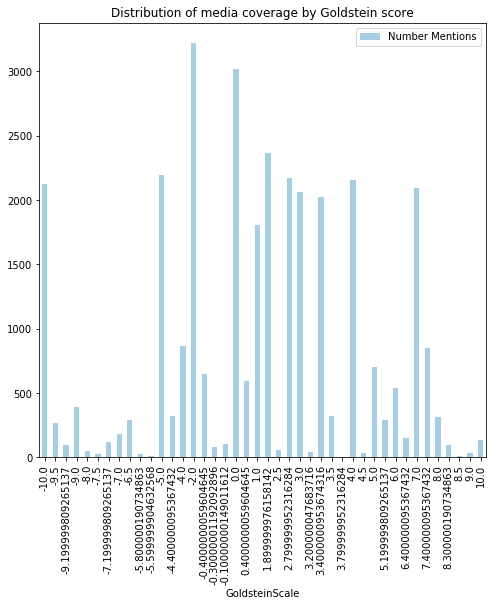

In [65]:
goldstein2.plot.bar(x='GoldsteinScale', y='Number Mentions', figsize=(8, 8), colormap='Paired', 
                    title='Distribution of media coverage by Goldstein score')

We observe here that the distribution of the mediatic coverage regarding the Goldstein score is very similar to the distribution of events regarding the Goldstein score. Indeed, most of the mentions are related to events with a Goldstein score around 0, in particular above 0 and a few mentions are related to events with score of -10. This would lead us to believe that the mentions are not related to the type of events, as they follow the same distribution as the events. Instead, the amount of mentions for a particular score seems to be associated to the amount of events for this score. We would like to do a deeper analysis of this relation in the next weeks. 

### QuadClass

Another way to assess the bias of media coverage and attention depending on the event type is to consider another classification of events. The Quad Class feature classifies events into four global catagories :
- Verbal cooperation
- Material cooperation
- Verbal conflict
- Material conflict

In order to have an idea of the distribution of events regarding the quad class in our dataset, we represented the percentage of events in each class :

In [66]:
#What is the distribution of the Quad Class type accross events
quad_val = ['Verbal Cooperation','Material Cooperation','Verbal Conflict','Material Conflict']
events.select('QuadClass').describe().show()

+-------+-----------------+
|summary|        QuadClass|
+-------+-----------------+
|  count|            52834|
|   mean|1.813983419767574|
| stddev|1.131066235636066|
|    min|                1|
|    max|                4|
+-------+-----------------+



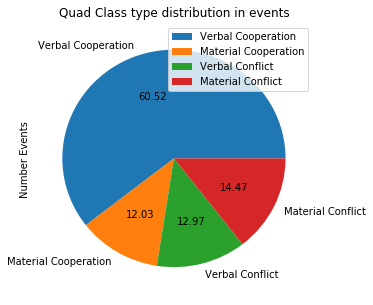

In [67]:
def get_class(labels):
    
    return [x for i,x in enumerate(quad_val) if (i+1) in labels]

def get_quad(df_events):
    
    return df_events.groupby('QuadClass').agg(count('GLOBALEVENTID').alias('Number Events')).orderBy('QuadClass')
    
def get_piechart_data(df,str1,str2):
    
    one_list = list(df.select(str1).toPandas()[str1])
    two_list = list(df.select(str2).toPandas()[str2])

    return pd.DataFrame({str1: one_list},index= two_list)

quad = get_piechart_data(get_quad(events),'Number Events','QuadClass')
quad.plot.pie(y='Number Events', autopct='%.2f',figsize=(5, 5),labels=get_class(list(quad.index)),title = 'Quad Class type distribution in events')


As the majority of reported events are related to Verbal Cooperation, the distribution between the four Quad classes is therefore not homogene. Thus, most activities related by the news are not conflictual. This is consistent with what we observed regarding the Goldstein score, where most of the reported events have a score above 0. We see though that more than 25% of the events related by the news are conflictual. 

The media attention index considered later on in our analysis should therefore take into consideration the inhomogenity of the distribution. The media coverage (resp. attention) should be a ratio between the number of mentions (resp. normalised number of mentions) per QuadClass type and the total number of events per QuadClass type. 

In [68]:
def get_cov_quad(df_events,df_mentions):
    
    df_mentions = get_media_cov(df_mentions).alias('mentions')
    df_events = df_events.alias('events')
    cov_quad = df_events.join(df_mentions, df_events['GLOBALEVENTID'] == df_mentions['GLOBALEVENTID'],how = 'left').select(['events.QuadClass','mentions.*']).sort('GLOBALEVENTID')

    return cov_quad

med_cov_byQuadClass = get_cov_quad(events,mentions)

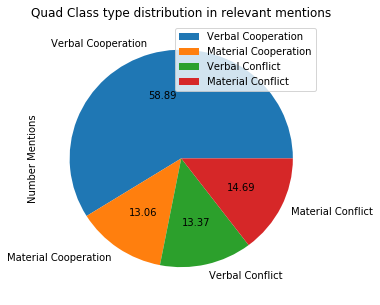

In [69]:
quad = med_cov_byQuadClass.groupby('QuadClass').agg(sum(med_cov_byQuadClass['Number Mentions']).alias('Number Mentions')).orderBy('QuadClass')

quad = get_piechart_data(quad,'Number Mentions','QuadClass')
quad.plot.pie(y='Number Mentions', autopct='%.2f',figsize=(5, 5),labels=get_class(list(quad.index)),title = 'Quad Class type distribution in relevant mentions')



We see here that once again, the distribution of mentions regarding the Quad class of the reported events is similar to the distribution of events regarding the Quad class. Thus, this would mean that the number of mentions regarding the Quad class is related to the number of events in this quad class and not to the quad class itself. We would like to further analyze with the rest of the dataset any association between media coverage, events and type of events in the next weeks, in order to determine whether there is any relation between the media coverage and the quad class, that is, if an event belonging to a certain class will be given more importance by the medias compared to another class.

### Violent and Peaceful Events 

On top of the Goldstein score and the quad class classification, the Event Root Code provides information on the specific type of an event. It stores this information in a CAMEO format which is a numerical values related to a specific category of event. The categories are PUBLIC STATEMENT, APPEAL, EXPRESS, COOPERATE, CONSULT, DIPLOMATIC COOPERATION, PROVIDE AID, YIELD, INVESTIGATE, DEMAND, DISAPPROVE, REJECT, THREATEN, PROTEST, FORCE POSTURE, REDUCE RELATIONS, COERCE, ASSAULT, FIGHT and MASS VIOLENCE. We represented the distribution of the events regarding their Event Root Code.

In [70]:
labels_val = ['PUBLIC STATEMENT','APPEAL', 'INTENT TO COOPERATE','CONSULT','DIPLOMATIC COOPERATION','MATERIAL COOPERATION',
          'PROVIDE AID','YIELD','INVESTIGATE','DEMAND','DISAPPROVE','REJECT','THREATEN','PROTEST','FORCE POSTURE',
          'REDUCE RELATIONS','COERCE','ASSAULT','FIGHT','MASS VIOLENCE']

# returns the proportion of events which are in each category of events
def get_activity_byType(df_events):

    total_event = df_events.count()
    udf = UserDefinedFunction(lambda x: x/total_event, DoubleType())

    root_type = df_events.groupby('EventRootCode').agg(count('GLOBALEVENTID').alias('Number of Events')).sort('EventRootCode')
    root_type = root_type.select([udf(column).alias('Percentage of Events') if column == 'Number of Events' else column for column in root_type.columns])

    return root_type 

# returns the label for the numerical values of the Event Root Code 
def get_reallabels(df):
    
    real_labels = df['EventRootCode'].values
    labels = [labels_val[int(x)-1] for x in real_labels]
    
    return labels


act_byType = get_activity_byType(events).toPandas()

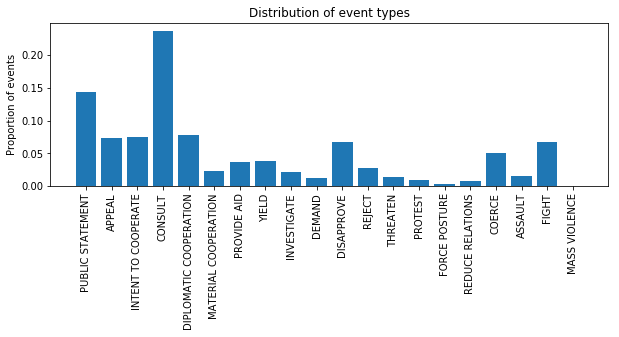

In [71]:
x_pos = np.arange(len(act_byType['EventRootCode']))
fig, ax = plt.subplots(figsize=(10,3))
ax.bar(x_pos, act_byType['Percentage of Events'])
ax.set_xticks(x_pos)
ax.set_ylabel('Proportion of events')
ax.set_title('Distribution of event types')
plt.xticks(x_pos, get_reallabels(act_byType), rotation='vertical')
plt.show()

We see that the sample of recorded events which we considered are mostly neutral events, with no violent character. Indeed, most of the events are consultation, public statement, intent to cooperate and diplomatic cooperation. Whereas less events are related to assault, threats and mass violence. However, almost 10% of the events are related to fight. Thus, most events reported by the news seem to be leading to better world conditions.

# Let's now concentrate on some countries.... 

We now want to observe different features for specific countries, in order to have an idea of the localized situation. We would like to know if we can already observe a relation between these features. We choose to do this analysis for :
- the USA, as they are highly prominent in the media and seem to be really active in terms of human activity, according to what is reported through the news
- Syria, as it is a country in war and would thus be expected to be unstable and present in the medias
- Pakistan, as it has been the target of terroristic attacks in the recent years and would also be expected to be the subject of the news
- Australia, as it is an occidental country in the South hemisphere

We thus looked throughout the months at the events, the media coverage and the Goldstein score. We also looked for these 4 countries at their distribution of event types across the 2 years.

In [72]:
# gives the average Goldstein ration per month
def get_Goldstein(df) :

    udf = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m').strftime('%m-%Y'))    
    df_Goldstein = df.groupBy('MonthYear_Date').agg(mean('GoldsteinScale').alias('av_Goldstein')).orderBy('MonthYear_Date')
    return df_Goldstein.select([udf(column).alias('Month_Year') if column == 'MonthYear_Date' else column for column in df_Goldstein.columns])


In [73]:
# events related to these countries
events_US = events.filter(events['ActionGeo_CountryCode'] == 'US')
events_SY = events.filter(events['ActionGeo_CountryCode'] == 'SY')
events_PK = events.filter(events['ActionGeo_CountryCode'] == 'PK')
events_AU = events.filter(events['ActionGeo_CountryCode'] == 'AU')

In [74]:
# mentions related to these countries
mentions_US = events_US.join(mentions, 'GLOBALEVENTID')
mentions_SY = events_SY.join(mentions, 'GLOBALEVENTID')
mentions_PK = events_PK.join(mentions, 'GLOBALEVENTID')
mentions_AU = events_AU.join(mentions, 'GLOBALEVENTID')

In [75]:
# Human activity per month
events_US_time = get_events_worldwide(events_US) 
events_SY_time = get_events_worldwide(events_SY) 
events_PK_time = get_events_worldwide(events_PK) 
events_AU_time = get_events_worldwide(events_AU) 

In [76]:
# Media coverage per month
mentions_US_time = get_media_coverage_worldwide(mentions_US)
mentions_SY_time = get_media_coverage_worldwide(mentions_SY)
mentions_PK_time = get_media_coverage_worldwide(mentions_PK)
mentions_AU_time = get_media_coverage_worldwide(mentions_AU)

In [77]:
# Goldstein per month
Goldstein_US = get_Goldstein(events_US)
Goldstein_SY = get_Goldstein(events_SY)
Goldstein_PK = get_Goldstein(events_PK)
Goldstein_AU = get_Goldstein(events_AU)

In [78]:
# Convert all Spark dataframes to Pandas dataframes for plotting
events_US_time_pd = events_US_time.toPandas()
events_SY_time_pd = events_SY_time.toPandas()
events_PK_time_pd = events_PK_time.toPandas()
events_AU_time_pd = events_AU_time.toPandas()

mentions_US_time_pd = mentions_US_time.toPandas()
mentions_SY_time_pd = mentions_SY_time.toPandas()
mentions_PK_time_pd = mentions_PK_time.toPandas()
mentions_AU_time_pd = mentions_AU_time.toPandas()

Goldstein_US_pd = Goldstein_US.toPandas()
Goldstein_SY_pd = Goldstein_SY.toPandas()
Goldstein_PK_pd = Goldstein_PK.toPandas()
Goldstein_AU_pd = Goldstein_AU.toPandas()

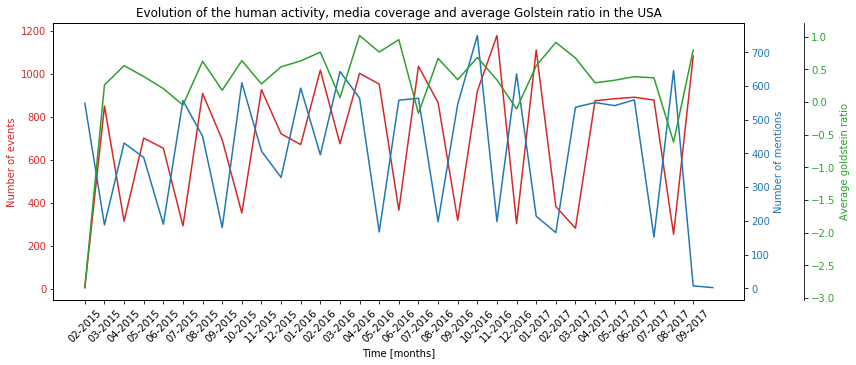

In [79]:
fig, ax1 = plt.subplots(figsize=(12,5))

color = 'tab:red'
ax1.set_xlabel('Time [months]')
plt.xticks(rotation=45)
ax1.set_ylabel('Number of events', color=color)
ax1.plot(events_US_time_pd['Month_Year'], events_US_time_pd['count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of mentions', color=color)  # we already handled the x-label with ax1
ax2.plot(mentions_US_time_pd['Month_Year_Mention'], mentions_US_time_pd['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('Average goldstein ratio', color=color)  # we already handled the x-label with ax1
ax3.plot(Goldstein_US_pd['Month_Year'], Goldstein_US_pd['av_Goldstein'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines['right'].set_position(('outward', 60)) 

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Evolution of the human activity, media coverage and average Golstein ratio in the USA')
plt.show()


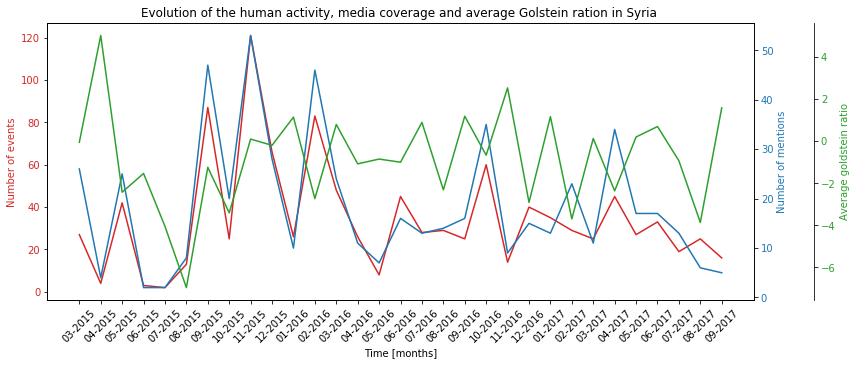

In [80]:
fig, ax1 = plt.subplots(figsize=(12,5))

color = 'tab:red'
ax1.set_xlabel('Time [months]')
plt.xticks(rotation=45)
ax1.set_ylabel('Number of events', color=color)
ax1.plot(events_SY_time_pd['Month_Year'], events_SY_time_pd['count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of mentions', color=color)  # we already handled the x-label with ax1
ax2.plot(mentions_SY_time_pd['Month_Year_Mention'], mentions_SY_time_pd['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('Average goldstein ratio', color=color)  # we already handled the x-label with ax1
ax3.plot(Goldstein_SY_pd['Month_Year'], Goldstein_SY_pd['av_Goldstein'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines['right'].set_position(('outward', 60)) 

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Evolution of the human activity, media coverage and average Golstein ration in Syria ')
plt.show()

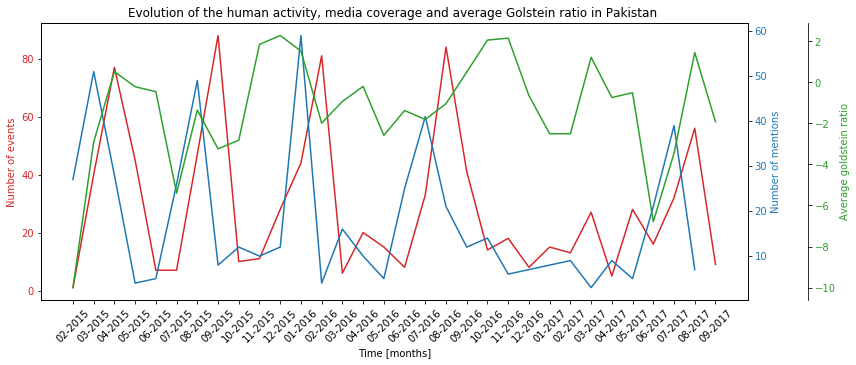

In [81]:
fig, ax1 = plt.subplots(figsize=(12,5))

color = 'tab:red'
ax1.set_xlabel('Time [months]')
plt.xticks(rotation=45)
ax1.set_ylabel('Number of events', color=color)
ax1.plot(events_PK_time_pd['Month_Year'], events_PK_time_pd['count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of mentions', color=color)  # we already handled the x-label with ax1
ax2.plot(mentions_PK_time_pd['Month_Year_Mention'], mentions_PK_time_pd['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('Average goldstein ratio', color=color)  # we already handled the x-label with ax1
ax3.plot(Goldstein_PK_pd['Month_Year'], Goldstein_PK_pd['av_Goldstein'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines['right'].set_position(('outward', 60)) 

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Evolution of the human activity, media coverage and average Golstein ratio in Pakistan ')
plt.show()

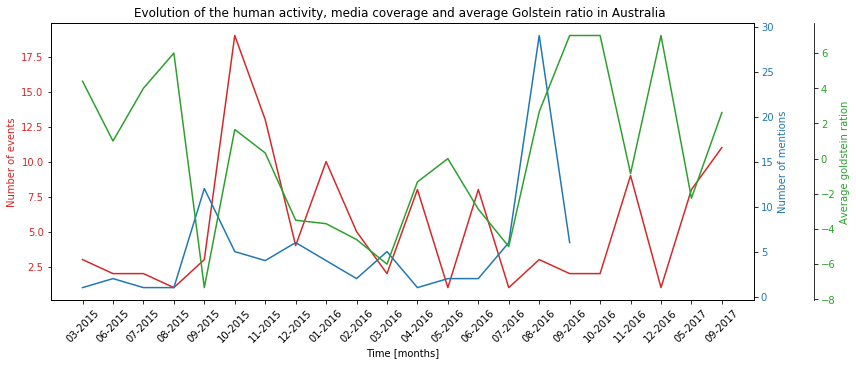

In [82]:
fig, ax1 = plt.subplots(figsize=(12,5))

color = 'tab:red'
ax1.set_xlabel('Time [months]')
plt.xticks(rotation=45)
ax1.set_ylabel('Number of events', color=color)
ax1.plot(events_AU_time_pd['Month_Year'], events_AU_time_pd['count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of mentions', color=color)  # we already handled the x-label with ax1
ax2.plot(mentions_AU_time_pd['Month_Year_Mention'], mentions_AU_time_pd['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('Average goldstein ration', color=color)  # we already handled the x-label with ax1
ax3.plot(Goldstein_AU_pd['Month_Year'], Goldstein_AU_pd['av_Goldstein'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines['right'].set_position(('outward', 60)) 

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Evolution of the human activity, media coverage and average Golstein ratio in Australia ')
plt.show()

Looking at these four countries, we observe certain behaviours across time. 
We see that in the US, there is a clear relation between the number of events and the media coverage each month, as the 2 curves are very close to each other. We also see that the peaks in the reported events happen simultaneously with the peaks in the average Goldstein score. This displays an interesting relation, where more events lead to more media coverage, but also where more reported events mean a slighlty higher Goldstein score, which could indicate that there are more news when the events are less neutral.

For Syria, Pakistan and Australia, there are significantly less reported events and less mentions compared to the US. In these countries, the number of mentions seems to be related to the number of events as well, as the two curves follow similar evolutions through time. We observe that Syria and Pakistan have the fewer numbers of reported events and mentions througout the months, although Syria is at war and Pakistan is the center of many conflicts due to political and military unstability, as well as the terroristic attacks by the Taliban Pakistan. This unstability is reflected by the evolution of the Goldstein score thoughout time, which tends to often go below 0. Australia however has an average Goldstein score which is maintained between 0 and 2, although it peaks downard for a few occasions. It is interesting to see that countries which are subject to violent conflicts are equally or less present in the medias compared to countries like Australia which would be considered more stable and in particular like the US.

After looking at the evolution througout the months, we looked at the average situation over the 2 years. We looked at the distribution of violent and peaceful events in the four countries, averaged over the 2 months. We considered ad violent the events with an Event Root Code above 18 (18 = Assault, 19 = Fight, 20 = Mass violence) and as peaceful the ones with a code below 3 (1 = Public statement, 2 = Appeal, 3= Expression of intent to cooperate).

In [83]:
def get_violentevents(df_events):
    
    violent_index = df_events['EventRootCode'] >= 18
    
    return df_events[violent_index]

violent = get_violentevents(events)

def get_peacefullevents(df_events):
    
    peace_index = df_events['EventRootCode'] <= 3
    
    return df_events[peace_index]

peace = get_peacefullevents(events)
extremes = peace.union(violent) 

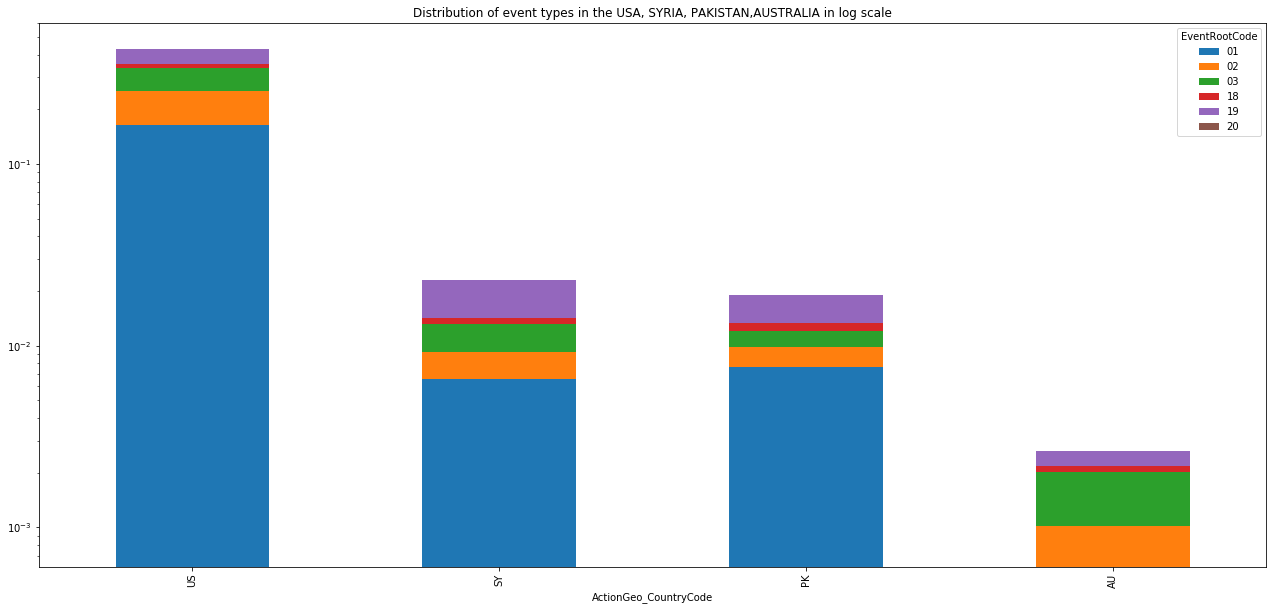

In [84]:
def get_activity_byTypeCountry(df_events):
    
    total_event = df_events.count()
    udf = UserDefinedFunction(lambda x: x/total_event, DoubleType())
    
    count_type = df_events.groupby('ActionGeo_CountryCode','EventRootCode').agg(count('GLOBALEVENTID').alias('Number of Events')).orderBy('ActionGeo_CountryCode','EventRootCode')    
    count_type = count_type.select([udf(column).alias('Percentage of Events') if column == 'Number of Events' else column for column in count_type.columns])

    return count_type

type_count = get_activity_byTypeCountry(extremes).toPandas()
type_count = type_count.pivot(index='ActionGeo_CountryCode', columns='EventRootCode', values='Percentage of Events')
type_count = type_count.loc[['US','SY','PK','AU']]
type_count.plot.bar(figsize = (22,10),stacked=True,logy=True, title = 'Distribution of event types in the USA, SYRIA, PAKISTAN,AUSTRALIA in log scale')

- 1: Public statement
- 2: Appeal
- 3: Expression of intent to cooperate
- 18: Assault
- 19: Fight
- 20: Use of unconventional mass violence

Considering the logarithmic scale on this bar chart, as displayed above, the US have far more reported events than the other countries and the majority of these events are pacific (public statement, appeal, expression of intent to cooperate). Eventhough less events were reported for Australia, these events were mostly pacific as well. On the other hand, Syria and Pakistan have an important proportion of violent events, which reflects what was displayed above by their average Goldstein scores. Indeed, their scores were fluctuating towards low values during the 2 years, indicating unstability. Looking at this, we are impressed by the amount of events reported by the medias in the US, eventhough the country appears to be stable. Whereas the activity of countries which are in critical situations like Syria and Pakistan and which would tend to be more interesting regarding their situation, is not so much reported in the medias.

After these primary observations of our data and of the behaviour of our data regarding certain features, we would like to do a deeper analysis using the whole dataset, in order to identify whether the different features are correlated, for example whether we can predict the state or stability of a country by looking at the media coverage. Thus we would like to identify whether it is accurate to say that medias are biases, by taking in consideration the fact that the medias which were reported in this database tend to mostly be american, and thus might not represent the whole picture of media coverage in the different countries.

# Cluster integration

Aside from exploring a local subset of datas, we also run a small query on the cluster to test our setup.
The computation took quite a long time, although our query was only to compute the sum of all mentions for avery country during the time period covered by the dataset.

In [ ]:
# mentions_per_country_fipsCode.csv was generated on the cluster and downloaded manually
mentionsPerCountry = spark.read.csv('mentions_per_country_fipsCode.csv', schema=StructType([
    StructField("alpha-2", StringType(), True),
    StructField("count", LongType(), True)]))

mentionsPerCountry = mentionsPerCountry.toPandas()
mentionsPerCountry = mentionsPerCountry.sort_values('count', ascending=False)
mentionsPerCountry['alpha-2'] = mentionsPerCountry['alpha-2'].apply(lambda x: fips2iso(x))
mentionsPerCountry.head(10)

In [ ]:
world_topo = json.load(open('world-countries-sans-antarctica.json'))


world_map = folium.Map(location=[30, 0], tiles='Mapbox Bright', zoom_start=1.5)
world_map.choropleth(geo_data=world_topo,
                     data=mentionsPerCountry,
                     columns=['alpha-2', 'count'],
                     topojson='objects.countries1',
                     fill_color='OrRd', fill_opacity=0.7,
                     key_on = 'properties.Alpha-2',
                  threshold_scale=[0, 24000, 240000, 2400000, 24000000, 240000000])



world_map

# MILESTONE 3

Each new function was first tried with a sample of the data, as for the second milestone. They were then run on the cluster with the whole dataset and visualized (see the results below).

We wanted to see what kind of information a mediatic source was relaying to the inhabitants of the country where it was written. Indeed, we wanted to see whether a media mostly transmits information about the country where it is written or if it displays informations about foreign countries. Thus we selected a few highly represented media sources and for each of them, we looked at :
- the number of times they mentioned each country, with respect to all the mentions of this media
- the number of events they mentioned in each country, with respect to the number of events which took place in the country during the 2 years


In [86]:
# Find the number of mentions per country per source
def mentions_biggest_sources1(df_mentions,df_events,selected_sources) :
    
    mentions_selected_sources = df_mentions.filter(col('MentionSourceName').isin(selected_sources))
    mentions_selected_sources = mentions_selected_sources.groupBy('MentionSourceName','GLOBALEVENTID').agg(count('GLOBALEVENTID').alias('Number_mentions_event'))
    mentions_selected_sources = mentions_selected_sources.join(df_events, 'GLOBALEVENTID').select('MentionSourceName','GLOBALEVENTID','Number_mentions_event','ActionGeo_CountryCode')
    return mentions_selected_sources.groupBy('MentionSourceName','ActionGeo_CountryCode').agg(sum('Number_mentions_event').alias('Number_Mentions'))


In [87]:
# Find the number of events mentioned per country per source, and the total number of events in each country
def mentions_biggest_sources2(df_mentions,df_events,selected_sources) :
    
    mentions_selected_sources = df_mentions.filter(col('MentionSourceName').isin(selected_sources))
    # for each sources finds the IDs of the events it mentiones
    mentions_selected_sources = mentions_selected_sources.groupBy('MentionSourceName','GLOBALEVENTID').count().select('MentionSourceName','GLOBALEVENTID')
    # find the country for each of these events
    mentions_selected_sources = mentions_selected_sources.join(df_events, 'GLOBALEVENTID').select('MentionSourceName','GLOBALEVENTID','ActionGeo_CountryCode')
    # finds the overall number of events for each country in the 2 years
    events_country = df_events.groupBy('ActionGeo_CountryCode').agg(count('GLOBALEVENTID').alias('Number_events_country'))
    # for each country mentioned in the sources, associates its number of events in the 2 years
    sources_events = mentions_selected_sources.join(events_country,'ActionGeo_CountryCode').select('MentionSourceName','GLOBALEVENTID','ActionGeo_CountryCode','Number_events_country')
    # finds the number of events in each country mentioned by theses specific media sources
    return sources_events.groupBy('MentionSourceName','ActionGeo_CountryCode','Number_events_country').agg(count('GLOBALEVENTID').alias('Number_events_source'))
                                                                                                                                                                                                                              

In [88]:
biggest_sources_selection = list(['dailymail.co.uk','couriermail.com.au','abc-7.com','english.wafa.ps'])
mentions_selected_sources1 = mentions_biggest_sources1(mentions.select('MentionSourceName', 'GLOBALEVENTID'),events.select('GLOBALEVENTID','ActionGeo_CountryCode'),biggest_sources_selection)
mentions_selected_sources2 = mentions_biggest_sources2(mentions.select('MentionSourceName', 'GLOBALEVENTID'),events.select('GLOBALEVENTID','ActionGeo_CountryCode'),biggest_sources_selection)


First we looked at the number of times the selected sources mentioned each country : 

In [89]:
mentions_selected_sources1.orderBy(['MentionSourceName','ActionGeo_CountryCode']).show()

+------------------+---------------------+---------------+
| MentionSourceName|ActionGeo_CountryCode|Number_Mentions|
+------------------+---------------------+---------------+
|         abc-7.com|                 null|              2|
|         abc-7.com|                   CH|              1|
|         abc-7.com|                   CO|              2|
|         abc-7.com|                   EG|              1|
|         abc-7.com|                   IZ|              2|
|         abc-7.com|                   RS|              1|
|         abc-7.com|                   TU|              7|
|         abc-7.com|                   US|             14|
|couriermail.com.au|                   AS|             11|
|couriermail.com.au|                   FR|              2|
|couriermail.com.au|                   NR|              2|
|couriermail.com.au|                   RS|              2|
|couriermail.com.au|                   TS|              2|
|couriermail.com.au|                   UK|              

We selected Daily Mail UK and looked, for each country, at the percentage of mentions abouth this country published by Daily Mail UK with respect to the number of mentions published by Daily Mail UK in total :

In [90]:
countries_mentions_biggest_sources_UK = mentions_selected_sources1.filter(mentions_selected_sources1['MentionSourceName']=='dailymail.co.uk').toPandas()
countries_mentions_biggest_sources_UK['Percentage_mentions']=(countries_mentions_biggest_sources_UK['Number_Mentions']*100)/countries_mentions_biggest_sources_UK['Number_Mentions'].sum()
countries_mentions_biggest_sources_UK.head(10)


,MentionSourceName,ActionGeo_CountryCode,Number_Mentions,Percentage_mentions
0,dailymail.co.uk,IR,6,2.097902
1,dailymail.co.uk,PK,1,0.349650
2,dailymail.co.uk,FR,6,2.097902
3,dailymail.co.uk,CA,3,1.048951
4,dailymail.co.uk,SY,2,0.699301
5,dailymail.co.uk,AF,3,1.048951
6,dailymail.co.uk,GL,2,0.699301
7,dailymail.co.uk,MX,3,1.048951
8,dailymail.co.uk,US,81,28.321678
9,dailymail.co.uk,SP,2,0.699301


For each source, we then looked at the number of events they mentioned in each country (Number_events_source), with respect to the number of events which took place in the country during the 2 years (Number_events_country) :

In [91]:
mentions_selected_sources2.orderBy(['MentionSourceName','ActionGeo_CountryCode']).show()

+------------------+---------------------+---------------------+--------------------+
| MentionSourceName|ActionGeo_CountryCode|Number_events_country|Number_events_source|
+------------------+---------------------+---------------------+--------------------+
|         abc-7.com|                   CH|                 1041|                   1|
|         abc-7.com|                   CO|                  126|                   2|
|         abc-7.com|                   EG|                  365|                   1|
|         abc-7.com|                   IZ|                  553|                   2|
|         abc-7.com|                   RS|                 1017|                   1|
|         abc-7.com|                   TU|                  688|                   7|
|         abc-7.com|                   US|                22332|                  14|
|couriermail.com.au|                   AS|                 1627|                  11|
|couriermail.com.au|                   FR|            

In [92]:
mentions_selected_sources2 = mentions_selected_sources2.toPandas()
mentions_selected_sources2['Percentage_events'] = (mentions_selected_sources2['Number_events_source']*100)/mentions_selected_sources2['Number_events_country']
mentions_selected_sources2.head()


,MentionSourceName,ActionGeo_CountryCode,Number_events_country,Number_events_source,Percentage_events
0,abc-7.com,IZ,553,2,0.361664
1,dailymail.co.uk,CH,1041,7,0.672430
2,dailymail.co.uk,HU,37,2,5.405405
3,dailymail.co.uk,MO,45,1,2.222222
4,dailymail.co.uk,EI,228,4,1.754386


When later evaluating this function on the cluster, we selected these mediatic sources :  

- sources france24.com 
- washingtonpost.com 
- theguardian.com
- thejakartapost.com
- thehindu.com
- dailytelegraph.com.au
- gulfnews.com
- japantimes.co.jp
- chinadaily.com.cn
- timesofisrael.com
- rt.com 
- kenyastar.com

We then looked again at the Goldstein score. We had already evaluated the number of events and the number of mentions worldwide for each Goldstein score. We then wanted to evaluate, instead of the number of mentions, the average number of mentions per event for each Goldstein score. We thought it would be more relevant than the number of mentions itsef, as it represents the average importance given to a category of event :

In [93]:
def Goldstein_mediaCov(df_mentions,df_events) : 
    
    # get_media_cov returns the number of mentions per event
    media_coverage = get_media_cov(df_mentions)
    # associates each event with its Goldstein score
    df =  media_coverage.join(df_events,'GLOBALEVENTID').select('GoldsteinScale','Number Mentions')
    # for each value of Golstein score, evaluate the average number of mentions per event
    return df.groupBy('GoldsteinScale').agg(avg('Number mentions').alias('Average media coverage per event'))
    

In [94]:
Goldstein_mediaCov(mentions.select('GLOBALEVENTID'),events.select('GLOBALEVENTID','GoldsteinScale')).show()


+--------------+--------------------------------+
|GoldsteinScale|Average media coverage per event|
+--------------+--------------------------------+
|          -0.4|              1.1343804537521816|
|           9.0|              1.2333333333333334|
|           5.0|              1.0685975609756098|
|           2.5|              1.3846153846153846|
|           8.5|                             1.0|
|           3.8|                             1.0|
|          -9.0|              1.0706521739130435|
|          -0.1|               1.216867469879518|
|           8.3|              1.3098591549295775|
|           3.4|              1.0790176187933795|
|           7.4|              1.1009055627425615|
|           7.0|              1.0833764888658726|
|           5.2|              1.0977443609022557|
|           3.2|              1.1219512195121952|
|          -4.0|              1.0881612090680102|
|           3.0|               1.098028769312733|
|          -0.3|              1.1369863013698631|


To follow this idea of giving more weight to certains categories of event, we computed for each event its media coverage (count) to compare it with its Goldstein score, in order to observe whether there is any relationship between the two :

In [95]:
def get_media_cov(df_mentions, df_events):

    goldstein = df_events.select('GLOBALEVENTID', 'GoldsteinScale')
    # evaluates the media coverage for each event in the mentions database
    ret = df_mentions.groupby('GLOBALEVENTID').count()
    # associates the media coverage of each event to the Goldstein score of the event
    return ret.join(goldstein, 'GLOBALEVENTID')

In [96]:
get_media_cov(mentions, events).show(10)

+-------------+-----+--------------+
|GLOBALEVENTID|count|GoldsteinScale|
+-------------+-----+--------------+
|    418238996|    1|           4.0|
|    418238998|    1|           1.9|
|    418239003|    1|           2.8|
|    418239004|    1|          -5.0|
|    418239005|    1|          -4.4|
|    418239006|    1|           0.4|
|    418239007|    1|           0.4|
|    418239008|    1|           1.9|
|    418239009|    1|           1.9|
|    418239010|    1|           1.9|
+-------------+-----+--------------+
only showing top 10 rows



We then wanted to calculate the number of events for each country for each month, to see the evolution of the human activity on a map through time :

In [97]:
def get_events_per_country(events_df):
    
    # to have a good visualization of the time
    udf = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m').strftime('%m-%Y'))
    
    # finds the number of events for each country for each month
    events_worldwide =  events_df.groupBy('MonthYear_Date','ActionGeo_CountryCode').agg(count('GLOBALEVENTID').alias('Number_Events')).orderBy(['MonthYear_Date','Number_Events'],ascending=[True,True])
    # changes the format of the month and year for better visualization
    return events_worldwide.select([udf(column).alias('Month_Year') if column == 'MonthYear_Date' else column for column in events_worldwide.columns])


In [98]:
events_country_time = get_events_per_country(events)
events_country_time.show()

+----------+---------------------+-------------+
|Month_Year|ActionGeo_CountryCode|Number_Events|
+----------+---------------------+-------------+
|   02-2015|                   IN|            1|
|   02-2015|                   MZ|            1|
|   02-2015|                   WS|            1|
|   02-2015|                   PK|            1|
|   02-2015|                   HK|            1|
|   02-2015|                   UK|            2|
|   02-2015|                   US|            5|
|   02-2015|                   KS|            7|
|   03-2015|                   AL|            1|
|   03-2015|                   MO|            1|
|   03-2015|                   BF|            1|
|   03-2015|                   MY|            1|
|   03-2015|                   GG|            1|
|   03-2015|                   AR|            1|
|   03-2015|                   ZI|            1|
|   03-2015|                   SW|            1|
|   03-2015|                   IV|            1|
|   03-2015|        

We did the same but we loooked at the media coverage, that is here the number of mentions about each country each month : 

In [99]:
# returns the media coverage for each country for each month
def get_media_cov_per_country(df_events,df_mentions):
    
    # associates the country of each event with the mentions and times of the mentions of the event 
    df = df_mentions.join(df_events,'GLOBALEVENTID').select('GLOBALEVENTID','ActionGeo_CountryCode','MentionTimeDate')
    # changes the time into a more relevant format, keeping only the month and year
    mentions_Year_Month = df.select(
        [udf_mention1(column).alias('Year_Month_Mention') if column == 'MentionTimeDate' else column for column in
         df.columns])  
    # number of mentions per country per month
    mentions_year_month = mentions_Year_Month.groupBy('Year_Month_Mention','ActionGeo_CountryCode').count().orderBy('Year_Month_Mention')
    # changes the time format for a better vizualisation
    mentions_month_year = mentions_year_month.select(
        [udf_mention2(column).alias('Month_Year_Mention') if column == 'Year_Month_Mention' else column for column in
         mentions_year_month.columns])
    return mentions_month_year

In [100]:
get_media_cov_per_country(events.select('GLOBALEVENTID', 'ActionGeo_CountryCode'),mentions.select('GLOBALEVENTID', 'MentionTimeDate')).show()


+------------------+---------------------+-----+
|Month_Year_Mention|ActionGeo_CountryCode|count|
+------------------+---------------------+-----+
|           03-2015|                   SZ|    1|
|           03-2015|                   BM|    1|
|           03-2015|                   IT|   11|
|           03-2015|                   TH|    8|
|           03-2015|                   AE|    1|
|           03-2015|                   AF|   10|
|           03-2015|                   KE|   21|
|           03-2015|                   SY|   26|
|           03-2015|                   SA|    4|
|           03-2015|                   UP|   12|
|           03-2015|                   YI|    4|
|           03-2015|                   EI|    2|
|           03-2015|                   ML|    4|
|           03-2015|                   CS|    1|
|           03-2015|                   NI|   57|
|           03-2015|                   AU|    1|
|           03-2015|                   UK|   21|
|           03-2015|

In order to look specifically at what is happening in a few selected countries (Syria, USA, Australia, Pakistan) as we started in milestone 2, we evaluated for each of these countries the average media coverage for peaceful events (public statement 01, appeal 02, expression to intent to cooperate 03), as well as for violent events (Assault 18, Fight 19, Use of unconventionnal mass violence 20), all months considered :


In [101]:
def get_av_media_coverage_country_type(df_mentions,df_events) :
    
    # select the peaceful and violent events
    violent = get_violentevents(df_events)
    peace = get_peacefullevents(df_events)
    df = peace.union(violent)
    df1 = df.join(df_mentions,'GLOBALEVENTID').select('GLOBALEVENTID','ActionGeo_CountryCode','EventRootCode')
    # evaluates the number of mentions per event for each selected root code and for each country
    df2 = df1.groupBy('ActionGeo_CountryCode','EventRootCode','GLOBALEVENTID').agg(count('GLOBALEVENTID').alias('Number_mentions'))
    # evaluates the average number of mentions per event for each selected root code anf for each country
    return df2.groupBy('ActionGeo_CountryCode','EventRootCode').agg(mean('Number_mentions').alias('Average media coverage per event'))



In [102]:
events_spe_countries = events.select('ActionGeo_CountryCode','GLOBALEVENTID','EventRootCode').filter(col('ActionGeo_CountryCode').isin(list(['US', 'AU', 'SY', 'PK'])))    
events_spe_countries = get_av_media_coverage_country_type(mentions,events_spe_countries).orderBy('ActionGeo_CountryCode','EventRootCode')
events_spe_countries.show()

+---------------------+-------------+--------------------------------+
|ActionGeo_CountryCode|EventRootCode|Average media coverage per event|
+---------------------+-------------+--------------------------------+
|                   AU|           01|                             1.0|
|                   AU|           02|                             1.0|
|                   AU|           03|                             1.0|
|                   AU|           18|                             1.0|
|                   AU|           19|                             1.4|
|                   PK|           01|              1.0240963855421688|
|                   PK|           02|                            1.04|
|                   PK|           03|                             1.0|
|                   PK|           18|                             1.0|
|                   PK|           19|                             1.0|
|                   SY|           01|              1.0350877192982457|
|     

For these specific countries, we also looked at the pacific and violent human activities throughout the months :

In [103]:
def get_activity_byTypeCountry_time(df_events):
    
    # select the pacific and violent event
    violent = get_violentevents(df_events)
    peace = get_peacefullevents(df_events)
    df = peace.union(violent)
    # counts the number of events or each country for each month for each root code
    df_new = df.groupby('ActionGeo_CountryCode','MonthYear_Date','EventRootCode').agg(count('GLOBALEVENTID').alias('Number of Events')).orderBy('ActionGeo_CountryCode', 'MonthYear_Date','EventRootCode')
    # changes the time into a better vizualisation format
    return df_new.select(
        [udf_mention2(column).alias('Month_Year') if column == 'MonthYear_Date' else column for column in df_new.columns])
    

In [104]:
events_spe_countries = events.filter(col('ActionGeo_CountryCode').isin(list(['US','AU','SY','PK'])))
type_events_countries = get_activity_byTypeCountry_time(events_spe_countries.select('GLOBALEVENTID','ActionGeo_CountryCode','MonthYear_Date', 'EventRootCode'))
type_events_countries.show()

+---------------------+----------+-------------+----------------+
|ActionGeo_CountryCode|Month_Year|EventRootCode|Number of Events|
+---------------------+----------+-------------+----------------+
|                   AU|   03-2015|           03|               2|
|                   AU|   07-2015|           03|               2|
|                   AU|   09-2015|           19|               2|
|                   AU|   10-2015|           02|               2|
|                   AU|   10-2015|           03|               7|
|                   AU|   10-2015|           18|               1|
|                   AU|   10-2015|           19|               1|
|                   AU|   11-2015|           02|               1|
|                   AU|   11-2015|           19|               1|
|                   AU|   12-2015|           02|               2|
|                   AU|   12-2015|           19|               2|
|                   AU|   01-2016|           01|               5|
|         

## Results vizualisation
We evaluated the functions designed for milestone 2 on the cluster and we visualized the results. We also visualized the results of the functions designed in milestone 3. The names of the files usually have the same name as the function which was used to get them. For the files which had different names, we specified newt to them the names of the function used.

#### Confidence analysis : number of mentions for each confidence index

In [105]:
confidence = pd.read_csv('./data/get_confidence.csv', header = 0)
confidence = confidence.sort_values('Confidence')

In [106]:
trace0 = go.Bar(
    x=confidence['Confidence'].apply(str),
    y=confidence['count'],
    text=confidence['count'],
    marker=dict(
        color='#AFEEEE',
        line=dict(
            color='#AFEEEE',
            width=1.5,
                )
                ),
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title='Number of Mentions by Confidence Index',
    xaxis=dict(
        title='Confidence Index',
        autorange=True,
        showgrid=False,

    ),
    yaxis=dict(
        title='Number of Mentions',
        autorange=True,
        showgrid=False,
    ),
    width=700,
    height=500,
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Confidence_Analysis')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ADAforever3/0 or inside your plot.ly account where it is named 'Confidence_Analysis'


#### Type of sources Analysis : number of event for each type of type of source

In [107]:
sources_type = pd.read_csv('./data/get_sources.csv', header = 0)
sources_type

,Number Mentions,MentionType
0,583040839,1
1,2196383,2


In [108]:
fig = {
  "data": [
    {
      "values": sources_type['Number Mentions'],
      "labels": ['Web Sources','Offline Sources'],
      #"text":'none',
      #"textposition":"inside",
      "domain": {"x": [0, 1]},
      "name": "Type",
      "hole": .4,
      "type": "pie",
      "marker" : {"colors":['#AFEEEE', '#1A76FF']}
    }],
  "layout": {
        "title":"Sources Type GDELT 2.0 Dataset"
    }
}
py.iplot(fig, filename='Source_Type_Analysis')

#### Goldstein  scale

Here we represent the number of events and the average media coverage per event for each Goldstein score.

In [109]:
# a changer pour avoir average & nb events
mentions_Golstein_data = pd.read_csv('./data/Goldstein_mediaCov.csv')
events_Golstein_data = pd.read_csv('./data/get_activity_byGoldstein_new.csv')

In [110]:
mentions_Golstein_data = mentions_Golstein_data.dropna().sort_values(by=['GoldsteinScale'])
events_Golstein_data = events_Golstein_data.dropna().sort_values(by=['GoldsteinScale'])

events_Golstein_data = mentions_Golstein_data

In [111]:
mentions_Golstein_data = mentions_Golstein_data.set_index(mentions_Golstein_data['GoldsteinScale'].astype(str))
events_Golstein_data = events_Golstein_data.set_index(events_Golstein_data['GoldsteinScale'].astype(str))

In [112]:
for i, j in enumerate(mentions_Golstein_data.index.values):
    events_Golstein_data.index.values[i] = events_Golstein_data.index.values[i] + '`'
    mentions_Golstein_data.index.values[i] = mentions_Golstein_data.index.values[i] + '`'

In [113]:
trace1 = go.Bar(
    #x=np.linspace(mentions_Golstein_data['GoldsteinScale'].min(),mentions_Golstein_data['GoldsteinScale'].max(),len(mentions_Golstein_data['GoldsteinScale'].values)),
    x = mentions_Golstein_data.index,
    y= mentions_Golstein_data['Average media coverage per event'],
    text='none',
    name = 'Average Media Coverage',
    marker=dict(
        color='rgb(26, 118, 255)',
        line=dict(
            color='rgb(26, 118, 255)',
            width=1.5),
    opacity=0.6),
    #yaxis='y1',
)
trace2 = go.Bar(
    #x=np.linspace(events_Golstein_data['GoldsteinScale'].min(),events_Golstein_data['GoldsteinScale'].max(),len(events_Golstein_data['GoldsteinScale'].values)),
    x = events_Golstein_data.index,
    y= events_Golstein_data['Average media coverage per event'],
    text='none',
    name='Percentage of Total Events',
    marker=dict(
        color='rgb(175,238,238)',
        line=dict(
            color='rgb(175,238,238)',
            width=1.5),
    opacity=0.6),
    #yaxis='y2'
)

data = [trace1, trace2]

layout = go.Layout(
    title='Human Activity & Mediatic Coverage by Goldstein Index',
    xaxis=dict(
        #ticks = 'hello',
        tickangle=-45,
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis1=dict(
        title='Average Number of Mentions',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        side='left',
        showgrid = False
    ),
    yaxis2=dict(
        title='Percentage of Total Number of Events',
        titlefont=dict(
            size=16,
            color='rgb(175,238,238)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(175,238,238)'
        ),
        side='right',
        showgrid=False,
    
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='style-bar')

Now we look at the relationship, for each event, between the Golstein score and the number of mentions.

In [114]:
events_Goldstein_data = spark.read.format("csv").option("header", "true").load('./data/get_media_cov.csv')
events_Goldstein_data.count()

73140856

First we visualized whethere there was any relationship between the Goldstein score and the number of mentions, through a scatter plot. We only selected 5000 events, in order to have a good visulalization, as too many events would crowd the image :

In [115]:
events_Goldstein_data = events_Goldstein_data.limit(5000).toPandas()
events_Goldstein_data['GoldsteinScale'] = events_Goldstein_data['GoldsteinScale'].astype(float)
events_Goldstein_data['count'] = events_Goldstein_data['count'].astype(int)
events_Goldstein_data.rename(columns={'count': 'Mediatic Coverage'}, inplace=True)
events_Goldstein_data.head()

,GLOBALEVENTID,Mediatic Coverage,GoldsteinScale
0,490575773,1,-5.0
1,491306540,2,0.0
2,491572592,1,0.0
3,491704521,5,0.0
4,492038822,1,-2.0


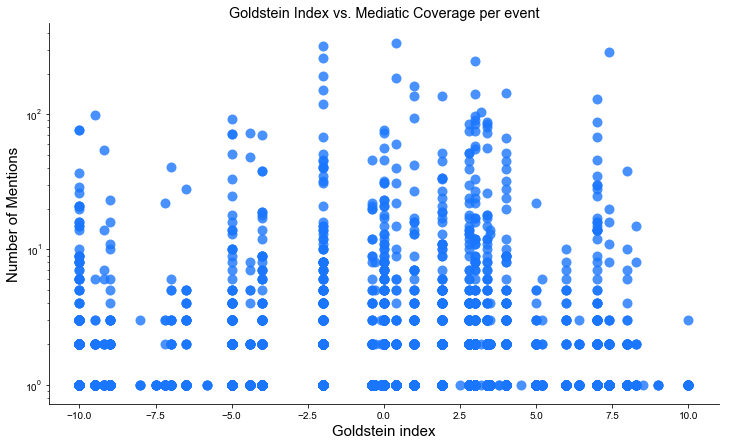

In [116]:
f, ax = plt.subplots(figsize=(12,7 ))
ax.set(yscale="log")
sns.set(font_scale=1.2)
sns.regplot(events_Goldstein_data['GoldsteinScale'],events_Goldstein_data['Mediatic Coverage'],fit_reg =False, ax=ax, scatter_kws={"color": "#1A76FF","s": 100}).set_title("Goldstein Index vs. Mediatic Coverage per event")
sns.set_style('ticks',{'legend.frameon':True,
                                'axes.facecolor': '1'})
sns.despine()
ax.set_xlabel('Goldstein index',fontsize=15);
ax.set_ylabel('Number of Mentions',fontsize=15);

In [117]:
f.savefig('./scatter_goldstein.svg')

As can be seen on the graph, there didn't seem to be any relationship between the 2 variables. However, we still wanted, as a next step, to observe the relationship through the evaluation of the correlation. We used Spearman and Pearson coefficient. The spearson coefficient was evaluated on normalized data. Only 70000 events were selected for the operation, as too many events would slow the process too much on the computer.

In [118]:
events_Goldstein_data = spark.read.format("csv").option("header", "true").load('./data/get_media_cov.csv')
df = events_Goldstein_data.limit(70000).toPandas()

In [119]:
event_count = pd.to_numeric(df['count'])
event_Goldsteinscore = pd.to_numeric(df['GoldsteinScale'])

# Function that normalize a data serie, by shifting its mean to 0 and variance to 1
def normalize(serie):
    return serie.apply(lambda x : (x-serie.mean())/serie.std())

import scipy.stats as stats
print(stats.spearmanr(event_count,event_Goldsteinscore))
print(stats.pearsonr(normalize(event_count),normalize(event_Goldsteinscore)))

SpearmanrResult(correlation=-0.02322587050130142, pvalue=7.960814607300896e-10)
(-0.005998895906248966, 0.11247989687093221)


According to the Pearson and Spearman coefficients, there were no linear nor monotonic relationship between the 2 variables. This means that an event with a greater potential to stabilize the country's stability (higher Golstein score) will not be mentioned more than an event with a great potential to destabilize a country. As the value of the correlation is negative, eventhough close to 0, if the type of an event were to influence the number of mentions it would receive, it would balance in the other direction. That is, an event with a negative effect on the counry's stabilitu would tend to receice more mentions.

#### Number of mentions for each QuadClass

In [120]:
# function : get_cov_quad
df_mentions_QuadClass = spark.read.format("csv").option("header", "true").load('./data/'+'get_cov_quad_relevant.csv')
quad_pie = get_piechart_data(df_mentions_QuadClass,'Number Mentions','QuadClass')
quad_pie['Number Mentions'] = pd.to_numeric(quad_pie['Number Mentions'])

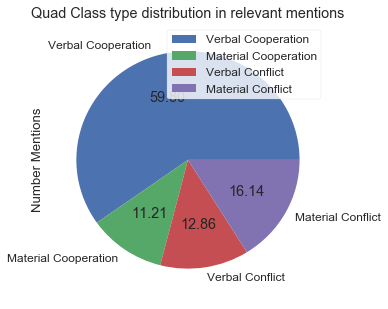

In [121]:
quad_val = ['Verbal Cooperation','Material Cooperation','Verbal Conflict','Material Conflict']
quad_pie.plot.pie(y='Number Mentions', autopct='%.2f',figsize=(5, 5),labels=get_class([int(i) for i in list(quad_pie.index)]),title = 'Quad Class type distribution in relevant mentions')


#### Number of events for each quad class

In [123]:
df_events_QuadClass = spark.read.format("csv").option("header", "true").load('./data/'+'get_quad.csv')
quad_pie = get_piechart_data(df_events_QuadClass,'Number Events','QuadClass')
quad_pie['Number Events'] = pd.to_numeric(quad_pie['Number Events'])

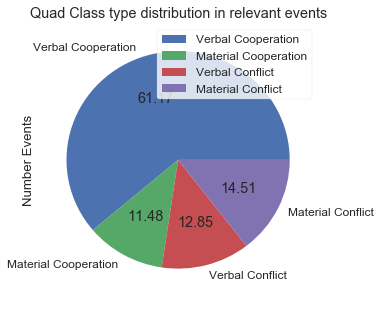

In [124]:
quad_pie.plot.pie(y='Number Events', autopct='%.2f',figsize=(5, 5),labels=get_class([int(i) for i in list(quad_pie.index)]),title = 'Quad Class type distribution in relevant events')


#### Number of events worldwide througout the months

Text(0.5,1,'Number of events worldwide during 2 years')

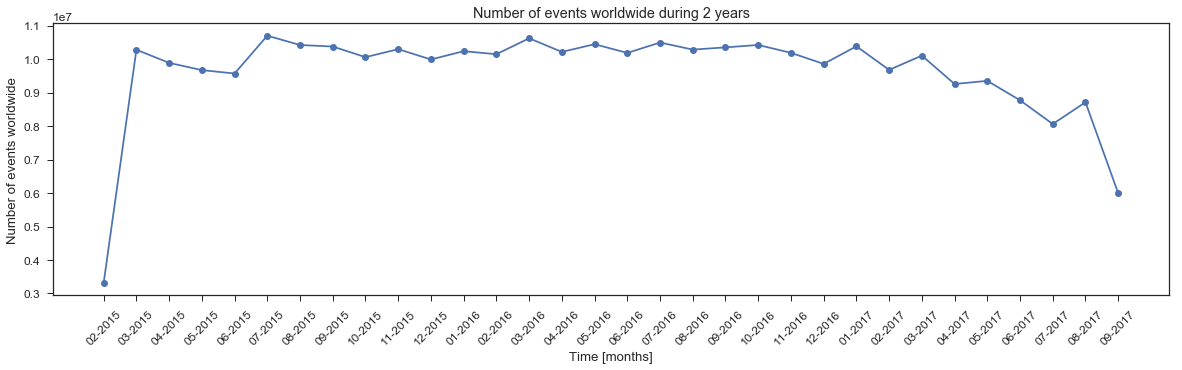

In [125]:
events_worldwide_time_data = pd.read_csv('./data/'+'get_events_worldwide.csv')
events_worldwide_time_data = events_worldwide_time_data.sort_values(by='MonthYear_Date')
events_worldwide_time_data['MonthYear_Date'] = events_worldwide_time_data['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

fig = plt.subplots(figsize=(20,5))
plt.plot(events_worldwide_time_data['MonthYear_Date'], events_worldwide_time_data['count'],marker='o')
plt.xlabel('Time [months]')
plt.ylabel('Number of events worldwide')
plt.xticks(rotation=45)
plt.title('Number of events worldwide during 2 years')

#### Number of mentions worldwide throughout the months

Text(0.5,1,'Number of mentions worldwide during 2 years')

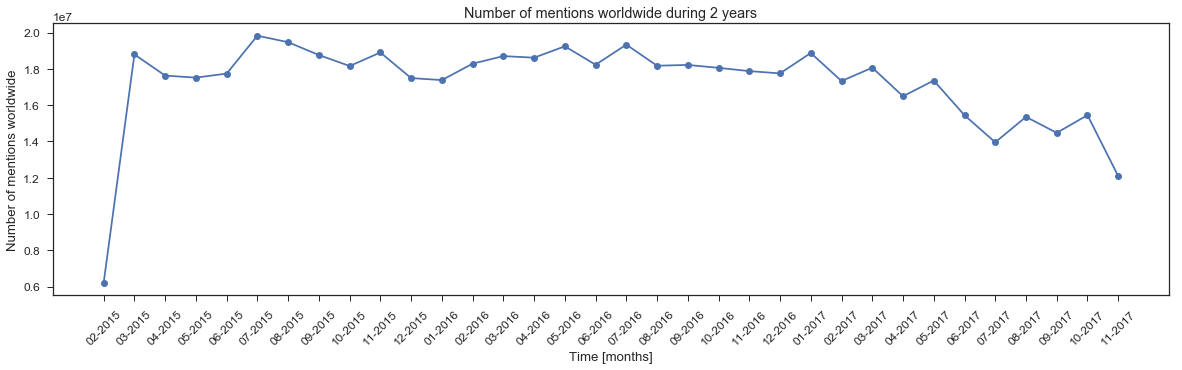

In [126]:
mentions_worldwide_time_data = pd.read_csv('./data/'+'get_media_coverage_worlwide.csv')
mentions_worldwide_time_data = mentions_worldwide_time_data.sort_values(by='MentionTimeDate')
mentions_worldwide_time_data['MentionTimeDate'] = mentions_worldwide_time_data['MentionTimeDate'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

fig = plt.subplots(figsize=(20,5))
plt.plot(mentions_worldwide_time_data['MentionTimeDate'], mentions_worldwide_time_data['count'],marker='o')
plt.xlabel('Time [months]')
plt.ylabel('Number of mentions worldwide')
plt.xticks(rotation=45)
plt.title('Number of mentions worldwide during 2 years')


#### Dynamic Maps of Human Activity & Mediatic Coverage

In [127]:
geo = json.load(open('./countries.geo.json'))
events_country_time_pd = pd.read_csv('./data/get_events_country_time.csv') # from function get_events_per_country
mentions_country_time_pd = pd.read_csv('./data/get_media_cov_per_country.csv')


In [128]:
def remove_missingISO(df):
    # removing countries that do not have ISO country codes and won't be recognized by json file
    #df = df[df.ActionGeo_CountryCode != 'US']
    df = df[df.ActionGeo_CountryCode != 'MQ']
    df = df[df.ActionGeo_CountryCode != 'PF']
    df = df[df.ActionGeo_CountryCode != 'PG']
    df = df[df.ActionGeo_CountryCode != 'CR']
    df = df[df.ActionGeo_CountryCode != 'YI']
    df = df[df.ActionGeo_CountryCode != 'DQ']
    df = df[df.ActionGeo_CountryCode != 'FQ']
    df = df[df.ActionGeo_CountryCode != 'EU']
    df = df[df.ActionGeo_CountryCode != 'GZ']
    df = df[df.ActionGeo_CountryCode != 'HQ']
    df = df[df.ActionGeo_CountryCode != 'IP']
    df = df[df.ActionGeo_CountryCode != 'JN']
    df = df[df.ActionGeo_CountryCode != 'JQ']
    df = df[df.ActionGeo_CountryCode != 'LQ']
    df = df[df.ActionGeo_CountryCode != 'KQ']
    df = df[df.ActionGeo_CountryCode != 'NT']
    df = df[df.ActionGeo_CountryCode != 'OC']
    df = df[df.ActionGeo_CountryCode != 'OS']
    df = df[df.ActionGeo_CountryCode != 'RB']
    df = df[df.ActionGeo_CountryCode != 'TE']
    df = df[df.ActionGeo_CountryCode != 'WQ']
    
    return df

In [129]:
events_country_time_pd = remove_missingISO(events_country_time_pd)
mentions_country_time_pd = remove_missingISO(mentions_country_time_pd)

events_across_times = pd.pivot_table(events_country_time_pd, values='count', index=['ActionGeo_CountryCode'], columns=['MonthYear_Date'])
mentions_across_times = pd.pivot_table(mentions_country_time_pd, values='count', index=['ActionGeo_CountryCode'], columns=['MentionTimeDate'])

In [130]:
def convert_ISO3(df):
    iso3 = np.asarray(df.index)
    for a, b in enumerate(df.index):
        iso3[a]=coco.convert(names=fips2iso(b), to='ISO3',not_found=None)
        
    return df.set_index(iso3,'Country_Code')

In [131]:
events_across_times = convert_ISO3(events_across_times)
mentions_across_times = convert_ISO3(mentions_across_times)

In [132]:
datetime_index1 = pd.date_range('2015-02', periods=32, freq='M')

dt_index_epochs1 = datetime_index1.astype(int) // 10**9
dt_index1 = dt_index_epochs1.astype('U10')

In [133]:
styledata1 = {}
styledata2 = {}

for country in events_across_times.index:

    my_colors = np.empty([32])
    
    for s in range(32):
        my_colors[s] = events_across_times.loc[country].values[s]
        
    df = pd.DataFrame(
        {'color': my_colors,
        'opacity':1},
        index=dt_index1
    )
    styledata1[country] = df


for country in mentions_across_times.index:
    
    my_colors = np.empty([32])
    
    for s in range(32):
        my_colors[s] = mentions_across_times.loc[country].values[s]
        
    df = pd.DataFrame(
        {'color': my_colors,
        'opacity':1},
        index=dt_index1
    )
    styledata2[country] = df



In [134]:
print(events_country_time_pd.loc[events_country_time_pd['count'].argmax()], '\n')
print(mentions_country_time_pd.loc[mentions_country_time_pd['count'].argmax()], '\n')
print(events_country_time_pd.loc[events_country_time_pd['count'].argmin()], '\n')
print(mentions_country_time_pd.loc[mentions_country_time_pd['count'].argmin()], '\n')

max_value1 = events_country_time_pd['count'].max()
min_value1 = events_country_time_pd['count'].min()

max_value2 = mentions_country_time_pd['count'].max()
min_value2 = mentions_country_time_pd['count'].min()

MonthYear_Date            201701
ActionGeo_CountryCode         US
count                    3490579
Name: 7032, dtype: object 

ActionGeo_CountryCode          US
MentionTimeDate            201607
count                    11892983
Name: 2597, dtype: object 

MonthYear_Date           201605
ActionGeo_CountryCode        BV
count                         1
Name: 5661, dtype: object 

ActionGeo_CountryCode        LS
MentionTimeDate          201710
count                         1
Name: 1991, dtype: object 



/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWar

In [135]:
k1 = (max_value1 - min_value1)/np.log(max_value1/min_value1)
c1 = min_value1 - k1 * np.log(min_value1)

k2 = (max_value2 - min_value2)/np.log(max_value2/min_value2)
c2 = min_value2 - k2 * np.log(min_value2)

events_across_times_log = events_across_times.apply(lambda x: (k1 * np.log(x)) + c1, axis = 1)
mentions_across_times_log = mentions_across_times.apply(lambda x: (k2 * np.log(x)) + c2, axis = 1)

In [136]:
cmap1 = linear.GnBu_04.scale(min_value1,max_value1)
cmap2 = linear.GnBu_04.scale(min_value2,max_value2)

In [137]:
for i, data in enumerate(styledata1.items()):
    if not np.isnan(styledata1[data[0]]['color']).any():
            styledata1[data[0]]['color'] = styledata1[data[0]]['color'].apply(cmap1)
            
for i, data in enumerate(styledata2.items()):
    if not np.isnan(styledata2[data[0]]['color']).any():
            styledata2[data[0]]['color'] = styledata2[data[0]]['color'].apply(cmap2)

In [138]:
styledict1 = {
    str(country): data.to_dict(orient='index') for
    country, data in styledata1.items()
}

styledict2 = {
    str(country): data.to_dict(orient='index') for
    country, data in styledata2.items()
}

In [139]:
m1 = folium.Map([10, 20], tiles='Mapbox Bright', zoom_start=1.4)

g = TimeSliderChoropleth(
    data = geo,
    styledict=styledict1,
    name = 'Human Activity',
    overlay = True)

m1.add_child(g)
m1.add_child(folium.map.LayerControl())


In [140]:
m2 = folium.Map([10, 20], tiles='Mapbox Bright', zoom_start=1.4)

e = TimeSliderChoropleth(
    data = geo,
    styledict=styledict2,
    name = 'Media Attention',
    overlay = True)

m2.add_child(e)
m2.add_child(folium.map.LayerControl())

In [141]:
m1.save(os.path.join('dynamic_events.html'))
m2.save(os.path.join('static_mentions.html'))

#### Static Maps of Human Activity & Mediatic Coverage

In [142]:
events_static = events_across_times.sum(axis = 1)
mentions_static = mentions_across_times.sum(axis = 1)

In [143]:
events_static = pd.DataFrame(
        {'Number Events': events_static.values},
        index=events_static.index)

In [144]:
mentions_static = pd.DataFrame(
        {'Number Mentions': mentions_static.values},
        index=mentions_static.index)

In [145]:
def get_countryNames(df):
    country_names = []

    for a, b in enumerate(df.index):
        country_names.append(coco.convert(names=b, to='name_short',not_found=None))

    df['Country Name'] = country_names
    return df  

In [146]:
events_static = get_countryNames(events_static)
mentions_static = get_countryNames(mentions_static)

###### Human activity

In [147]:
df = events_static

max_static = df['Number Events'].max()
min_static = df['Number Events'].min()

In [148]:
data = [ dict(
        type = 'choropleth',
        locations = df.index,
        z = df['Number Events'],
        text = df['Country Name'],
        colorscale = [[0,"#f7fcf0"],[0.35,"#c0e7c1"],[0.5,"#9bd8c0"],\
            [0.6,"#88d1c3"],[0.7,"#73c6c4"],[1,"#2b8cbe"]],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(247,244,249)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            #ticksuffix = ' events',
            title = 'Human Activity <br> (millions of events)'),
      ) ]

layout = dict(
    title = 'Human Activity between February 2015 and September 2017<br>Source: GDELT 2.0 Dataset',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

###### Mediatic coverage

In [149]:
df = mentions_static

max_static = df['Number Mentions'].max()
min_static = df['Number Mentions'].min()

In [150]:
data = [ dict(
        type = 'choropleth',
        locations = df.index,
        z = df['Number Mentions'],
        text = df['Country Name'],
        colorscale = [[0,"#f7fcf0"],[0.35,"#c0e7c1"],[0.5,"#9bd8c0"],\
            [0.6,"#88d1c3"],[0.7,"#73c6c4"],[1,"#2b8cbe"]],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(247,244,249)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            #ticksuffix = ' mentions',
            title = 'Mediatic Coverage <br> (millions of mentions)'),
      ) ]

layout = dict(
    title = 'Mediatic Coverage between February 2015 and September 2017 <br>Source: GDELT 2.0 Dataset',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

####  Representation throughout times for some countries..... (human activity, media coverage, peaceful events, violent events, Goldstein score)

In [151]:
# Human activity per month for Syria, USA, Australia, Pakistan 
# (function: for example get_events_worldwide(events_US) )
events_US = pd.read_csv('./data/'+'events_US_time.csv')
events_US = events_US.sort_values(by='MonthYear_Date')
events_US['MonthYear_Date'] = events_US['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

events_AS = pd.read_csv('./data/'+'events_AS_time.csv')
events_AS = events_AS.sort_values(by='MonthYear_Date')
events_AS['MonthYear_Date'] = events_AS['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

events_PK = pd.read_csv('./data/'+'events_PK_time.csv')
events_PK = events_PK.sort_values(by='MonthYear_Date')
events_PK['MonthYear_Date'] = events_PK['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

events_SY = pd.read_csv('./data/'+'events_SY_time.csv')
events_SY = events_SY.sort_values(by='MonthYear_Date')
events_SY['MonthYear_Date'] = events_SY['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))


In [152]:
# Mentions per month for Syria, USA, Australia, Pakistan
# (function : for example get_media_coverage_worldwide(mentions_US))
mentions_US = pd.read_csv('./data/'+'mentions_US_time.csv')
mentions_US = mentions_US.sort_values(by='MentionTimeDate')
mentions_US['MentionTimeDate'] = mentions_US['MentionTimeDate'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

mentions_AS = pd.read_csv('./data/'+'mentions_AS_time.csv')
mentions_AS = mentions_AS.sort_values(by='MentionTimeDate')
mentions_AS['MentionTimeDate'] = mentions_AS['MentionTimeDate'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

mentions_PK = pd.read_csv('./data/'+'mentions_PK_time.csv')
mentions_PK = mentions_PK.sort_values(by='MentionTimeDate')
mentions_PK['MentionTimeDate'] = mentions_PK['MentionTimeDate'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

mentions_SY = pd.read_csv('./data/'+'mentions_SY_time.csv')
mentions_SY = mentions_SY.sort_values(by='MentionTimeDate')
mentions_SY['MentionTimeDate'] = mentions_SY['MentionTimeDate'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))



In [153]:
# Average Goldstein score per month for Syria, USA, Australia, Pakistan 
# (function : for example get_Goldstein(events_US))
goldstein_US = pd.read_csv('./data/'+'Goldstein_US.csv')
goldstein_US = goldstein_US.sort_values(by='MonthYear_Date')
goldstein_US['MonthYear_Date'] = goldstein_US['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

goldstein_AS = pd.read_csv('./data/'+'Goldstein_AS.csv')
goldstein_AS = goldstein_AS.sort_values(by='MonthYear_Date')
goldstein_AS['MonthYear_Date'] = goldstein_AS['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

goldstein_PK = pd.read_csv('./data/'+'Goldstein_PK.csv')
goldstein_PK = goldstein_PK.sort_values(by='MonthYear_Date')
goldstein_PK['MonthYear_Date'] = goldstein_PK['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

goldstein_SY = pd.read_csv('./data/'+'Goldstein_SY.csv')
goldstein_SY = goldstein_SY.sort_values(by='MonthYear_Date')
goldstein_SY['MonthYear_Date'] = goldstein_SY['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))



In [154]:
# Violent events and peaceful events per month for Syria, USA, Australia, Pakistan
activity_by_type = pd.read_csv('./data/'+'get_activity_byTypeCountry_time.csv')

peaceful_events = activity_by_type[activity_by_type['EventRootCode'].isin(['01','02','03'])]
violent_events = activity_by_type[activity_by_type['EventRootCode'].isin(['18','19','20'])]

peaceful_events_US = peaceful_events[peaceful_events['ActionGeo_CountryCode']=='US'].sort_values(by='MonthYear_Date')
peaceful_events_US = peaceful_events_US.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
peaceful_events_US['MonthYear_Date'] = peaceful_events_US['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

peaceful_events_AS = peaceful_events[peaceful_events['ActionGeo_CountryCode']=='AS'].sort_values(by='MonthYear_Date')
peaceful_events_AS = peaceful_events_AS.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
peaceful_events_AS['MonthYear_Date'] = peaceful_events_AS['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))


peaceful_events_PK = peaceful_events[peaceful_events['ActionGeo_CountryCode']=='PK'].sort_values(by='MonthYear_Date')
peaceful_events_PK = peaceful_events_PK.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
peaceful_events_PK['MonthYear_Date'] = peaceful_events_PK['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))


peaceful_events_SY = peaceful_events[peaceful_events['ActionGeo_CountryCode']=='SY'].sort_values(by='MonthYear_Date')
peaceful_events_SY = peaceful_events_SY.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
peaceful_events_SY['MonthYear_Date'] = peaceful_events_SY['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))


violent_events_US = violent_events[violent_events['ActionGeo_CountryCode']=='US'].sort_values(by='MonthYear_Date')
violent_events_US = violent_events_US.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
violent_events_US['MonthYear_Date'] = violent_events_US['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

violent_events_AS = violent_events[violent_events['ActionGeo_CountryCode']=='AS'].sort_values(by='MonthYear_Date')
violent_events_AS = violent_events_AS.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
violent_events_AS['MonthYear_Date'] = violent_events_AS['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))


violent_events_SY = violent_events[violent_events['ActionGeo_CountryCode']=='SY'].sort_values(by='MonthYear_Date')
violent_events_SY = violent_events_SY.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
violent_events_SY['MonthYear_Date'] = violent_events_SY['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))


violent_events_PK = violent_events[violent_events['ActionGeo_CountryCode']=='PK'].sort_values(by='MonthYear_Date')
violent_events_PK = violent_events_PK.groupby(by='MonthYear_Date',as_index=False).sum().sort_values(by='MonthYear_Date').drop(columns='EventRootCode')
violent_events_PK['MonthYear_Date'] = violent_events_PK['MonthYear_Date'].astype(str).apply(lambda x : datetime.strptime(x,'%Y%m').strftime('%m-%Y'))




In [155]:
##### USA #####

trace1 = go.Scatter(
    x=events_US['MonthYear_Date'],
    y=events_US['count'],
    name='Events',
    yaxis='y1',
    line = dict(
        color = '#1f77b4')
)
trace2 = go.Scatter(
    x=goldstein_US['MonthYear_Date'],
    y=goldstein_US['avg(GoldsteinScale)'],
    name='Goldstein score',
    yaxis='y2',
    line = dict(
        color = '#ff7f0e')
)
trace3 = go.Scatter(
    x=peaceful_events_US['MonthYear_Date'],
    y=peaceful_events_US['count'],
    name='Peaceful events',
    yaxis='y3',
    line = dict(
        color = '#d62728')
    
)
trace4 = go.Scatter(
    x=violent_events_US['MonthYear_Date'],
    y=violent_events_US['count'],
    name='Violent events',
    yaxis='y3',
    line = dict(
        color = '#d62728',
        dash = 'dot')
)
trace5 = go.Scatter(
    x=mentions_US['MentionTimeDate'],
    y=mentions_US['count'],
    name='Mentions',
    yaxis='y4',
    line = dict(
        color = '#9467bd')
)



data = [trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title='Evolution across the months for the United States of America',
    width=1200,
    xaxis=dict(
        domain=[0.02, 0.7],
        showgrid=False),
    yaxis=dict(
        title='Number of events',
        showgrid=False,
        titlefont=dict(
            color='#1f77b4'
        ),
        tickfont=dict(
            color='#1f77b4'
        ),
        side='right',
        position=0.72
    ),
    yaxis2=dict(
        title='Average Goldstein score',
        showgrid=False,
        titlefont=dict(
            color='#ff7f0e'
        ),
        tickfont=dict(
            color='#ff7f0e'
        ),
        overlaying='y',
        side='left',
        position=0
    ),
    yaxis3=dict(
        title='Number of events (pacific or violent)',
        showgrid=False,
        titlefont=dict(
            color='#d62728'
        ),
        tickfont=dict(
            color='#d62728'
        ),
        overlaying='y',
        side='right',
        position=0.78
    ),
    yaxis4=dict(
        title='Number of mentions',
        showgrid=False,
        titlefont=dict(
            color='#9467bd'
        ),
        tickfont=dict(
            color='#9467bd'
        ),
        overlaying='y',
        side='right',
        position=0.84
    )
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='multiple-axes-multiple')
#py.iplot(fig,filename = 'test')

In [156]:
##### AUSTRALIA #####

trace1 = go.Scatter(
    x=events_AS['MonthYear_Date'],
    y=events_AS['count'],
    name='Events',
    yaxis='y1',
    line = dict(
        color = '#1f77b4')
)
trace2 = go.Scatter(
    x=goldstein_AS['MonthYear_Date'],
    y=goldstein_AS['avg(GoldsteinScale)'],
    name='Goldstein score',
    yaxis='y2',
    line = dict(
        color = '#ff7f0e')
)
trace3 = go.Scatter(
    x=peaceful_events_AS['MonthYear_Date'],
    y=peaceful_events_AS['count'],
    name='Peaceful events',
    yaxis='y3',
    line = dict(
        color = '#d62728')
    
)
trace4 = go.Scatter(
    x=violent_events_AS['MonthYear_Date'],
    y=violent_events_AS['count'],
    name='Violent events',
    yaxis='y3',
    line = dict(
        color = '#d62728',
        dash = 'dot')
)
trace5 = go.Scatter(
    x=mentions_AS['MentionTimeDate'],
    y=mentions_AS['count'],
    name='Mentions',
    yaxis='y4',
    line = dict(
        color = '#9467bd')
)



data = [trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title='Evolution across the months for Australia',
    width=1200,
    xaxis=dict(
        domain=[0.02, 0.7],
        showgrid=False),
    yaxis=dict(
        title='Number of events',
        showgrid=False,
        titlefont=dict(
            color='#1f77b4'
        ),
        tickfont=dict(
            color='#1f77b4'
        ),
        side='right',
        position=0.72
    ),
    yaxis2=dict(
        title='Average Goldstein score',
        showgrid=False,
        titlefont=dict(
            color='#ff7f0e'
        ),
        tickfont=dict(
            color='#ff7f0e'
        ),
        overlaying='y',
        side='left',
        position=0
    ),
    yaxis3=dict(
        title='Number of events (pacific or violent)',
        showgrid=False,
        titlefont=dict(
            color='#d62728'
        ),
        tickfont=dict(
            color='#d62728'
        ),
        overlaying='y',
        side='right',
        position=0.78
    ),
    yaxis4=dict(
        title='Number of mentions',
        showgrid=False,
        titlefont=dict(
            color='#9467bd'
        ),
        tickfont=dict(
            color='#9467bd'
        ),
        overlaying='y',
        side='right',
        position=0.84
    )
)
fig = go.Figure(data=data, layout=layout)
#plot_url = py.plot(fig, filename='multiple-axes-multiple')
#py.iplot(fig,filename = 'test')

In [157]:
##### PAKISTAN #####

trace1 = go.Scatter(
    x=events_PK['MonthYear_Date'],
    y=events_PK['count'],
    name='Events',
    yaxis='y1',
    line = dict(
        color = '#1f77b4')
)
trace2 = go.Scatter(
    x=goldstein_PK['MonthYear_Date'],
    y=goldstein_PK['avg(GoldsteinScale)'],
    name='Goldstein score',
    yaxis='y2',
    line = dict(
        color = '#ff7f0e')
)
trace3 = go.Scatter(
    x=peaceful_events_PK['MonthYear_Date'],
    y=peaceful_events_PK['count'],
    name='Peaceful events',
    yaxis='y3',
    line = dict(
        color = '#d62728')
    
)
trace4 = go.Scatter(
    x=violent_events_PK['MonthYear_Date'],
    y=violent_events_PK['count'],
    name='Violent events',
    yaxis='y3',
    line = dict(
        color = '#d62728',
        dash = 'dot')
)
trace5 = go.Scatter(
    x=mentions_PK['MentionTimeDate'],
    y=mentions_PK['count'],
    name='Mentions',
    yaxis='y4',
    line = dict(
        color = '#9467bd')
)



data = [trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title='Evolution across the months for Pakistan',
    width=1200,
    xaxis=dict(
        domain=[0.02, 0.7],
        showgrid=False),
    yaxis=dict(
        title='Number of events',
        showgrid=False,
        titlefont=dict(
            color='#1f77b4'
        ),
        tickfont=dict(
            color='#1f77b4'
        ),
        side='right',
        position=0.72
    ),
    yaxis2=dict(
        title='Average Goldstein score',
        showgrid=False,
        titlefont=dict(
            color='#ff7f0e'
        ),
        tickfont=dict(
            color='#ff7f0e'
        ),
        overlaying='y',
        side='left',
        position=0
    ),
    yaxis3=dict(
        title='Number of events (pacific or violent)',
        showgrid=False,
        titlefont=dict(
            color='#d62728'
        ),
        tickfont=dict(
            color='#d62728'
        ),
        overlaying='y',
        side='right',
        position=0.78
    ),
    yaxis4=dict(
        title='Number of mentions',
        showgrid=False,
        titlefont=dict(
            color='#9467bd'
        ),
        tickfont=dict(
            color='#9467bd'
        ),
        overlaying='y',
        side='right',
        position=0.84
    )
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='multiple-axes-multiple')
#py.iplot(fig,filename = 'test')

In [158]:
##### SYRIA #####
trace1 = go.Scatter(
    x=events_SY['MonthYear_Date'],
    y=events_SY['count'],
    name='Events',
    yaxis='y1',
    line = dict(
        color = '#1f77b4')
)
trace2 = go.Scatter(
    x=goldstein_SY['MonthYear_Date'],
    y=goldstein_SY['avg(GoldsteinScale)'],
    name='Goldstein score',
    yaxis='y2',
    line = dict(
        color = '#ff7f0e')
)
trace3 = go.Scatter(
    x=peaceful_events_SY['MonthYear_Date'],
    y=peaceful_events_SY['count'],
    name='Peaceful events',
    yaxis='y3',
    line = dict(
        color = '#d62728')
    
)
trace4 = go.Scatter(
    x=violent_events_SY['MonthYear_Date'],
    y=violent_events_SY['count'],
    name='Violent events',
    yaxis='y3',
    line = dict(
        color = '#d62728',
        dash = 'dot')
)
trace5 = go.Scatter(
    x=mentions_SY['MentionTimeDate'],
    y=mentions_SY['count'],
    name='Mentions',
    yaxis='y4',
    line = dict(
        color = '#9467bd')
)



data = [trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title='Evolution across the months for Syria',
    width=1200,
    xaxis=dict(
        domain=[0.02, 0.7],
        showgrid=False),
    yaxis=dict(
        title='Number of events',
        showgrid=False,
        titlefont=dict(
            color='#1f77b4'
        ),
        tickfont=dict(
            color='#1f77b4'
        ),
        side='right',
        position=0.72
    ),
    yaxis2=dict(
        title='Average Goldstein score',
        showgrid=False,
        titlefont=dict(
            color='#ff7f0e'
        ),
        tickfont=dict(
            color='#ff7f0e'
        ),
        overlaying='y',
        side='left',
        position=0
    ),
    yaxis3=dict(
        title='Number of events (pacific or violent)',
        showgrid=False,
        titlefont=dict(
            color='#d62728'
        ),
        tickfont=dict(
            color='#d62728'
        ),
        overlaying='y',
        side='right',
        position=0.78
    ),
    yaxis4=dict(
        title='Number of mentions',
        showgrid=False,
        titlefont=dict(
            color='#9467bd'
        ),
        tickfont=dict(
            color='#9467bd'
        ),
        overlaying='y',
        side='right',
        position=0.84
    )
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='multiple-axes-multiple')
#py.iplot(fig,filename = 'test')

#### Representation for some countries over the 2 years of the number of peaceful and violent events, as well as the average media coverage per event for these events

In [159]:
# Total number of peaceful and violent events for USA, Australia, Syria, Pakistan
peaceUS = peaceful_events_US['count'].sum()
peaceAS = peaceful_events_AS['count'].sum()
peacePK = peaceful_events_PK['count'].sum()
peaceSY = peaceful_events_SY['count'].sum()

violentUS = violent_events_US['count'].sum()
violentAS = violent_events_AS['count'].sum()
violentPK = violent_events_PK['count'].sum()
violentSY = violent_events_SY['count'].sum()
peaceUS

29071274

In [160]:
# Average media coverage per violent and per peaceful events for USA, Australia, Syria, Pakistan
average_media_coverage_by_type = pd.read_csv('./data/'+'get_av_media_coverage_country_type.csv')
average_media_coverage_by_type = average_media_coverage_by_type.drop(average_media_coverage_by_type[average_media_coverage_by_type['ActionGeo_CountryCode']=='ActionGeo_CountryCode'].index)
average_media_coverage_by_type['Average media coverage per event']=pd.to_numeric(average_media_coverage_by_type['Average media coverage per event'])

peaceful_coverage = average_media_coverage_by_type[average_media_coverage_by_type['EventRootCode'].isin(['01','02','03'])]
violent_coverage = average_media_coverage_by_type[average_media_coverage_by_type['EventRootCode'].isin(['18','19','20'])]

peace_coverage_US = peaceful_coverage[peaceful_coverage['ActionGeo_CountryCode']=='US']['Average media coverage per event'].mean()
peace_coverage_AS = peaceful_coverage[peaceful_coverage['ActionGeo_CountryCode']=='AS']['Average media coverage per event'].mean()
peace_coverage_PK = peaceful_coverage[peaceful_coverage['ActionGeo_CountryCode']=='PK']['Average media coverage per event'].mean()
peace_coverage_SY = peaceful_coverage[peaceful_coverage['ActionGeo_CountryCode']=='SY']['Average media coverage per event'].mean()

violent_coverage_US = violent_coverage[violent_coverage['ActionGeo_CountryCode']=='US']['Average media coverage per event'].mean()
violent_coverage_AS = violent_coverage[violent_coverage['ActionGeo_CountryCode']=='AS']['Average media coverage per event'].mean()
violent_coverage_PK = violent_coverage[violent_coverage['ActionGeo_CountryCode']=='PK']['Average media coverage per event'].mean()
violent_coverage_SY = violent_coverage[violent_coverage['ActionGeo_CountryCode']=='SY']['Average media coverage per event'].mean()


In [161]:
# Number of pacific and violent events

trace1 = go.Bar(
    x=['USA', 'Australia', 'Pakistan', 'Syria'],
    y=[peaceUS,peaceAS,peacePK,peaceSY],
    name='Peaceful events',
    marker=dict(
        color='rgb(26, 118, 255)'
    ),
    width = 0.6
)
trace2 = go.Bar(
    x=['USA', 'Australia', 'Pakistan', 'Syria'],
    y=[violentUS,violentAS,violentPK,violentSY],
    name='Violent events',
    marker=dict(
        color='rgb(175,238,238)'
    ),
    width=0.6
)

data = [trace1, trace2]
layout = go.Layout(
    width=500,
    barmode='stack',
    title='Number of events'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [162]:
# Average number of mentions per event for violent and peaceful events

trace1 = go.Bar(
    x=['USA', 'Australia', 'Pakistan', 'Syria'],
    y=[peace_coverage_US,peace_coverage_AS,peace_coverage_PK,peace_coverage_SY],
    name='Peaceful events',
    marker=dict(
        color='rgb(26, 118, 255)'
    ),
    width = 0.6
)
trace2 = go.Bar(
    x=['USA', 'Australia', 'Pakistan', 'Syria'],
    y=[violent_coverage_US,violent_coverage_AS,violent_coverage_PK,violent_coverage_SY],
    name='Violent events',
    marker=dict(
        color='rgb(175,238,238)'
    ),
    width = 0.6
)

data = [trace1, trace2]
layout = go.Layout(
    width=500,
    title='Average media coverage per event',
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')
#plot_url = py.plot(fig, filename='multiple-axes-multiple')

####  Now let's look at the countries  mentioned in specific selected sources....

First for each country mentioned by a source, we look at the number of mentions of the country by the source with respect to the total number of mentions by the source. This, in order to see how a source will represent foreign countries.

In [163]:
# function : mentions_biggest_sources1
countries_mentions_biggest_sources1 = pd.read_csv('./data/'+'countries_mentions_biggest_sources1_new.csv')
countries_mentions_biggest_sources1['MentionSourceName'].unique()

array(['japantimes.co.jp', 'washingtonpost.com', 'france24.com',
       'timesofisrael.com', 'thehindu.com', 'dailytelegraph.com.au',
       'gulfnews.com', 'rt.com', 'chinadaily.com.cn',
       'thejakartapost.com', 'kenyastar.com', 'theguardian.com'],
      dtype=object)

In [164]:
countries_mentions_biggest_sources1.head(5)

,MentionSourceName,ActionGeo_CountryCode,Number_Mentions
0,japantimes.co.jp,VE,635
1,washingtonpost.com,PL,4799
2,washingtonpost.com,BE,4063
3,france24.com,KZ,332
4,france24.com,JM,31


In [165]:
def remove_missingISO(df):
    #df = df[df.ActionGeo_CountryCode != 'US']
    df = df[df.ActionGeo_CountryCode != 'MQ']
    df = df[df.ActionGeo_CountryCode != 'PF']
    df = df[df.ActionGeo_CountryCode != 'PG']
    df = df[df.ActionGeo_CountryCode != 'CR']
    df = df[df.ActionGeo_CountryCode != 'YI']
    df = df[df.ActionGeo_CountryCode != 'DQ']
    df = df[df.ActionGeo_CountryCode != 'FQ']
    df = df[df.ActionGeo_CountryCode != 'EU']
    df = df[df.ActionGeo_CountryCode != 'GZ']
    df = df[df.ActionGeo_CountryCode != 'HQ']
    df = df[df.ActionGeo_CountryCode != 'IP']
    df = df[df.ActionGeo_CountryCode != 'JN']
    df = df[df.ActionGeo_CountryCode != 'JQ']
    df = df[df.ActionGeo_CountryCode != 'LQ']
    df = df[df.ActionGeo_CountryCode != 'KQ']
    df = df[df.ActionGeo_CountryCode != 'NT']
    df = df[df.ActionGeo_CountryCode != 'OC']
    df = df[df.ActionGeo_CountryCode != 'OS']
    df = df[df.ActionGeo_CountryCode != 'RB']
    df = df[df.ActionGeo_CountryCode != 'TE']
    df = df[df.ActionGeo_CountryCode != 'WQ']
    
    return df

In [166]:
# countries cleaning to remove the NaN or wrong named countries and display the real names of the countries
countries_mentions_biggest_sources1 = countries_mentions_biggest_sources1.dropna()
countries_mentions_biggest_sources1= remove_missingISO(countries_mentions_biggest_sources1)
x1 = countries_mentions_biggest_sources1.set_index('ActionGeo_CountryCode')
x2 = convert_ISO3(x1)
x3 = get_countryNames(x2)

In [167]:
# select the countries mentions in a specific source
# for each of these countries, look at the number of mentions from the source with respect 
# to the total number of sources
x4=x3[x3['MentionSourceName']=='france24.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of france24.com (France)',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='france24.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [168]:
x4=x3[x3['MentionSourceName']=='japantimes.co.jp']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of japantimes.co.jp ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='japantimes.co.jp')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [169]:
x4=x3[x3['MentionSourceName']=='washingtonpost.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]
layout = go.Layout(
    title = 'Media coverage of washingtonpost.com (USA)',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='washingtonpost.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [170]:
x4=x3[x3['MentionSourceName']=='timesofisrael.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of timesofisrael.com ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='timesofisrael.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [171]:
x4=x3[x3['MentionSourceName']=='thehindu.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of thehindu.com ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='thehindu.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [172]:
x4=x3[x3['MentionSourceName']=='theguardian.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of theguardian.com ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='theguardian.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [173]:
x4=x3[x3['MentionSourceName']=='kenyastar.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of kenyastar.com (Kenya)',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='kenyastar.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [174]:
x4=x3[x3['MentionSourceName']=='thejakartapost.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of thejakartapost.com ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='thejakartapost.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [175]:
x4=x3[x3['MentionSourceName']=='chinadaily.com.cn']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]


layout = go.Layout(
    title = 'Media coverage of chinadaily.com.cn ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chinadaily.com.cn')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [176]:
x4=x3[x3['MentionSourceName']=='rt.com']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]

layout = go.Layout(
    title = 'Media coverage of rt.com (Russia) ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='rt.com')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [177]:
x4=x3[x3['MentionSourceName']=='dailytelegraph.com.au']
x4['Percentage_mentions']=(x4['Number_Mentions']*100)/(x4['Number_Mentions'].sum())
x4 = x4.sort_values(by='Percentage_mentions',ascending=False).head(30)

data = [go.Bar(
            x=x4['Country Name'],
            y=x4['Percentage_mentions']
    )]
layout = go.Layout(
    title = 'Media coverage of dailytelegraph.com.au ',
    yaxis = dict(
        range = [0, 70],
        title = 'Percentage of mentions [%]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='dailytelegraph.com.au')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Then for each country mentioned by a source, we look at the number of events relayed by the source with respect to the total number of events which took place in the country. This will represent how much of a country's activity is relayed by the source. 

In [178]:
# function : mentions_biggest_sources2
countries_mentions_biggest_sources2 = pd.read_csv('./data/'+'mentions_biggest_sources2_new.csv')
countries_mentions_biggest_sources2['MentionSourceName'].unique()


array(['timesofisrael.com', 'theguardian.com', 'gulfnews.com',
       'france24.com', 'chinadaily.com.cn', 'dailytelegraph.com.au',
       'washingtonpost.com', 'japantimes.co.jp', 'thehindu.com', 'rt.com',
       'thejakartapost.com', 'kenyastar.com'], dtype=object)

In [179]:
countries_mentions_biggest_sources2.head()

,MentionSourceName,ActionGeo_CountryCode,Number_events_country,Number_events_source
0,timesofisrael.com,LT,50946,13
1,theguardian.com,LT,50946,40
2,gulfnews.com,LT,50946,52
3,france24.com,LT,50946,23
4,chinadaily.com.cn,LT,50946,19


In [181]:
# countries cleaning to remove the NaN or wrong named countries and display the real names of the countries
countries_mentions_biggest_sources2 = countries_mentions_biggest_sources2.dropna()
countries_mentions_biggest_sources2 = remove_missingISO(countries_mentions_biggest_sources2)
y1 = countries_mentions_biggest_sources2.set_index('ActionGeo_CountryCode')
y2 = convert_ISO3(y1)
y3 = get_countryNames(y2)

In [182]:
# select specific source and look for each country at the number of events mentioned by the source 
# with respect to the number of events which took place in the country
y4=y3[y3['MentionSourceName']=='washingtonpost.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'washingtonpost.com events relayed',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='washingtonpost.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [183]:
y4=y3[y3['MentionSourceName']=='france24.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'france24.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='france24.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [184]:
y4=y3[y3['MentionSourceName']=='timesofisrael.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'timesofisrael.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='timesofisrael.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [185]:
y4=y3[y3['MentionSourceName']=='theguardian.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'theguardian.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='theguardian.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [186]:
y4=y3[y3['MentionSourceName']=='gulfnews.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'gulfnews.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='gulfnews.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [187]:
y4=y3[y3['MentionSourceName']=='chinadaily.com.cn']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'chinadaily.com.cn events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chinadaily.com.cn events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [188]:
y4=y3[y3['MentionSourceName']=='dailytelegraph.com.au']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'dailytelegraph.com.au events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='dailytelegraph.com.au events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [189]:
y4=y3[y3['MentionSourceName']=='japantimes.co.jp']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'japantimes.co.jp events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='japantimes.co.jp events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [192]:
y4=y3[y3['MentionSourceName']=='thehindu.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'thehindu.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='dthehindu.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [193]:
y4=y3[y3['MentionSourceName']=='rt.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'rt.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='rt.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [194]:
y4=y3[y3['MentionSourceName']=='thejakartapost.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'thejakartapost.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='thejakartapost.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [195]:
y4=y3[y3['MentionSourceName']=='kenyastar.com']
y4['Percentage_events']=(y4['Number_events_source']*100)/y4['Number_events_country']
y4 = y4.sort_values(by='Percentage_events',ascending=False).head(30)

data = [go.Bar(
            x=y4['Country Name'],
            y=y4['Percentage_events']
    )]

layout = go.Layout(
    title = 'kenyastar.com events relayed',

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='kenyastar.com events relayed')

/Users/alicebizeul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

